# Librairies and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from adjustText import adjust_text
from collections import Counter
from tqdm import tqdm
import json, gc

In [64]:
plt.ion()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
n = 2
plt.rc('axes', linewidth=n)
ticksSizeMajor = 10
ticksSizeMinor = 5
ticksWidth = n
ticksLabelSize = 20
axisLabelSize = 25
titleSize = 30
legendSize = 20

In [ ]:
path_input = r'/my/path/input/'
path_output = r'/my/path/output/'

# Read datasets

- `citationNetwork.csv`
- `citationNetwork_nodes.csv`
- `papersNeuroAI_minRef10_minImp10_from1970.csv`
- `papersNeuro_minRef10_minImp10_from1970.csv`
- `wos_abb.json`

## Global citation network

In [4]:
allCN = pd.read_csv(f'{path_input}citationNetwork.csv', sep=',', index_col='Unnamed: 0')
allNeuroPapers = pd.read_csv(f'{path_input}citationNetwork_nodes.csv', sep=';')

In [5]:
allCN.drop_duplicates(inplace=True)

## Egocentered $\mathcal{P}\cap AI$ dataset

In [9]:
# only papers in queryLevel=0, published since 1970 and that have at least 10 references and 10 impacts
NeuroAIPapers_subset = pd.read_csv(f'{path_input}papersNeuroAI_minRef10_minImp10_from1970.csv', sep=';')
len(NeuroAIPapers_subset)

26374

In [10]:
NeuroAICN = allCN[allCN['citing'].isin(NeuroAIPapers_subset['id'])
                  | allCN['cited'].isin(NeuroAIPapers_subset['id'])]
NeuroAIPapers = allNeuroPapers[allNeuroPapers['id'].isin(set(NeuroAICN['citing'])|set(NeuroAICN['cited']))]

In [11]:
NeuroAICN

citing       cited
64961           233906  2108694113
64964           233906  2165707697
83138           296994  2065461085
98273           355896  2059586821
113181          414044  2066700516
...                ...         ...
1627277044  3028586449  2064675550
1627277988  3028587596  1988115241
1627282422  3028593627  2031132539
1627282431  3028593627  2235196730
1627282439  3028593627  2775079417

[2852268 rows x 2 columns]

## Egocentered $\mathcal{P}\cap \overline{AI}$ dataset

In [15]:
# only papers in queryLevel=0, published since 1970 and that have at least 10 references and 10 impacts, but which are not treating AI
NeuroPapers_subset = pd.read_csv(f'{path_input}papersNeuro_minRef10_minImp10_from1970.csv', sep=';')
len(NeuroPapers_subset)

829317

In [16]:
NeuroCN = allCN[allCN['citing'].isin(NeuroPapers_subset['id'])
                | allCN['cited'].isin(NeuroPapers_subset['id'])]
NeuroPapers = allNeuroPapers[allNeuroPapers['id'].isin(set(NeuroCN['citing'])|set(NeuroCN['cited']))]

In [17]:
NeuroCN

citing       cited
307                763   117192379
308                763   126741968
309                763   134541578
310                763   389589487
311                763  1526091749
...                ...         ...
1627283203  3028594672  2736304919
1627283473  3028594750  1965664348
1627283479  3028594750  1991385448
1627283491  3028594750  2037188404
1627283506  3028594750  2096481958

[75655300 rows x 2 columns]

## WoS discipline abbreviations

In [110]:
with open(f'{path_input}wos_abb.json', 'r', encoding='utf8') as bj:
    wos_abb = json.load(bj)

### Count how many references and citations that have a WOS JSC in each corpus

#### $\mathcal{P}\cap AI$

In [21]:
sub_NeuroAICN = NeuroAICN[NeuroAICN['cited'].isin(NeuroAIPapers_subset['id']) 
                         | NeuroAICN['citing'].isin(NeuroAIPapers_subset['id'])]
ids_refCit_NeuroAI = set(sub_NeuroAICN['cited']) | set(sub_NeuroAICN) - set(NeuroAIPapers_subset['id'])

In [22]:
a_AI = len(ids_refCit_NeuroAI)
a_AI

651045

In [23]:
b_AI = len(NeuroAIPapers[NeuroAIPapers['id'].isin(ids_refCit_NeuroAI) & (NeuroAIPapers['wos_domains']!='-1')])
b_AI

524708

In [24]:
b_AI/a_AI

0.8059473615495089

#### $\mathcal{P}\cap \overline{AI}$

In [93]:
sub_NeuroCN = NeuroCN[NeuroCN['cited'].isin(NeuroPapers_subset['id']) 
                         | NeuroCN['citing'].isin(NeuroPapers_subset['id'])]
ids_refCit_Neuro = set(sub_NeuroCN['cited']) | set(sub_NeuroCN) - set(NeuroPapers_subset['id'])

In [36]:
a_nonAI = len(ids_refCit_Neuro)
a_nonAI

5738314

In [94]:
b_nonAI = len(NeuroPapers[NeuroPapers['id'].isin(ids_refCit_Neuro) & (NeuroPapers['wos_domains']!='-1')])
b_nonAI

4816280

In [48]:
b_nonAI/a_nonAI

0.8393197026164828

#### All together

In [51]:
(b_AI+b_nonAI)/(a_AI+a_nonAI)

0.8359192213178191

## Cumulative number of publication and ratio of AI-related ones

In [12]:
ratio = []
n_Neuro = []
n_Neuro_cumul = [0]
n_NeuroAI = []
n_NeuroAI_cumul = [0]
for y in tqdm(set(NeuroPapers_subset['publicationYear'])):
    u = len(NeuroAIPapers_subset[papers_subset['publicationYear']==y])
    v = len(NeuroPapers_subset[NeuroPapers_subset['publicationYear']==y])
    n_Neuro.append(v)
    n_NeuroAI.append(u)
    n_Neuro_cumul.append(sum(n_Neuro[-2:]))
    n_NeuroAI_cumul.append(sum(n_NeuroAI[-2:]))
    ratio.append(u/(v+u))

100%|██████████████████████████████████████████| 51/51 [00:00<00:00, 233.36it/s]


<Figure size 432x288 with 0 Axes>

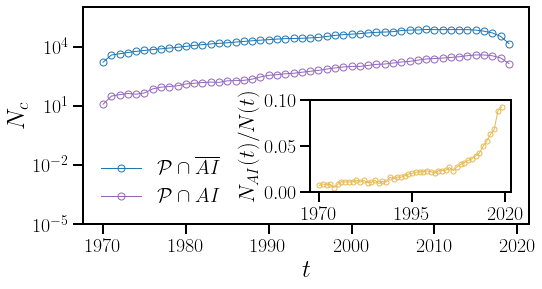

In [36]:
cmap = plt.cm.tab20.colors
cmap1 = plt.cm.tab20b.colors
plt.clf()
fig = plt.figure(figsize=(8, 4))
ax = plt.axes()
ax.plot(np.arange(1970, 2020), n_Neuro_cumul[1:-1], marker='o', mfc='none', 
        linewidth=1, color=cmap[0], markersize=7, label=r'$\mathcal{P}\cap\overline{AI}$')
ax.plot(np.arange(1970, 2020), n_NeuroAI_cumul[1:-1], marker='o', mfc='none', 
        linewidth=1, color=cmap[8], markersize=7, label=r'$\mathcal{P}\cap AI$')
ax.set_xlabel(r'$t$', fontsize=axisLabelSize)
ax.set_yscale('log')
ax.set_ylabel(r'$N_c$', fontsize=axisLabelSize)
ax.set_ylim(1e-5,1e6)
ax.set_xticks([i for i in range(1970, 2021, 10)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
ax.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
ax.legend(loc='lower left', ncol=1, fontsize=legendSize, frameon=False)

axins = inset_axes(ax, width='75%', height='85%',
                   bbox_to_anchor=(0.37, 0.125, 0.6, 0.5),
                   bbox_transform=ax.transAxes, loc=4)
axins.plot(np.arange(1970, 2020), ratio[:-1], marker='o', mfc='none', linewidth=1, color=cmap1[10], markersize=5)
axins.set_ylabel(r'$N_{AI}(t)/N(t)$', fontsize=axisLabelSize-3)
axins.set_ylim(0,0.1)
axins.set_xticks([i for i in range(1970, 2021, 25)])
axins.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)

#plt.tight_layout()
plt.savefig(f'{pics_folder}nbpublication_ratio.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Count the number of references and citations per year for each set

We consider the contributions of all reference or impact (citations) papers within the associated discipline appearing in the citations datasets.
We thus count the citations in order to give weight to the disciplines for two reasons:
- make appear some discipline that could be underrepresented if we take the abolute set of reference or impact papers alone
- indicate what disciplines are more cited or citing our papers under study
- allow the ranking of some papers that are more cited or citing our papers, eg. we can have a single paper that are cited a lot but in a single discipline that is not represented by all the other papers in reference or impact

<b> WARNING: </b> we consider here the citations obtained within the one year period following the effective publication date of the papers, in order to capture the disciplines which will use at first the published work. We can change this period after publication in the following cells.

## Subset of citations and impact of papers in $\mathcal{P}\cap AI$

In [27]:
NeuroAI_disciplines_ref = {}
NeuroAI_disciplines_imp = {}

for y in set(NeuroAIPapers_subset['publicationYear']):
    ids = NeuroAIPapers_subset[NeuroAIPapers_subset['publicationYear']==y]['id']
        
    # ----------------REFERENCE--------------
        
    IDrefs = Counter(NeuroAICN[NeuroAICN['citing'].isin(ids)]['cited'])
    disciplines_ref = []
    for i in IDrefs.keys():
        d = NeuroAIPapers[NeuroAIPapers['id']==i]['wos_domains'].values[0]
        if eval(d) != -1:
            disciplines_ref += [j for j in eval(d)]*IDrefs[i]
    NeuroAI_disciplines_ref[y] = dict(Counter(disciplines_ref))
        
    # ----------------IMPACT--------------
        
    citing_ids = NeuroAICN[NeuroAICN['cited'].isin(ids)]['citing']
    # filter with the period, keeping only NeuroAIPapers that have been published 1 year after the main NeuroAIPapers
    citing_ids = NeuroAIPapers[(NeuroAIPapers['id'].isin(citing_ids)) & (NeuroAIPapers['publicationYear']>=y) 
                       & (NeuroAIPapers['publicationYear'] <= y+1)]['id'] # change the period here
    IDimp = Counter(NeuroAICN[NeuroAICN['citing'].isin(citing_ids)]['citing'])
    disciplines_imp = []
    for i in IDimp.keys():
        d = eval(NeuroAIPapers[NeuroAIPapers['id']==i]['wos_domains'].values[0])
        if d != -1:
            disciplines_imp += [j for j in d]*IDimp[i]
    NeuroAI_disciplines_imp[y] = dict(Counter(disciplines_imp))
    print(y)

1970


In [130]:
# save the citations counts 
with open(f'{path_output}NeuroAI_disciplines_ref.json', 'w', encoding='utf8') as bj:
    json.dump(NeuroAI_disciplines_ref,bj)
with open(f'{path_output}NeuroAI_disciplines_imp.json', 'w', encoding='utf8') as bj:
    json.dump(NeuroAI_disciplines_imp,bj)

In [69]:
# compute the ratio of citations toward (cited) or from (citing) each discipline at each year
NeuroAI_disciplines_ref_prop = {y:{k:NeuroAI_disciplines_ref[y][k]/sum(NeuroAI_disciplines_ref[y].values()) for k in sorted(NeuroAI_disciplines_ref[y], key=NeuroAI_disciplines_ref[y].get)} for y in NeuroAI_disciplines_ref.keys()}
NeuroAI_disciplines_imp_prop = {y:{k:NeuroAI_disciplines_imp[y][k]/sum(NeuroAI_disciplines_imp[y].values()) for k in sorted(NeuroAI_disciplines_imp[y], key=NeuroAI_disciplines_imp[y].get)} for y in NeuroAI_disciplines_imp.keys()}

In [70]:
dfAI = pd.DataFrame({k: dict(NeuroAI_disciplines_ref[k]) for k in NeuroAI_disciplines_ref.keys()}).T.fillna(0).astype('int')
dfAI.index = [int(i) for i in dfAI.index]
dfAI2 = pd.DataFrame({k: dict(NeuroAI_disciplines_imp[k]) for k in NeuroAI_disciplines_imp.keys()}).T.fillna(0).astype('int')
dfAI2.index = [int(i) for i in dfAI2.index]

In [71]:
# compute aggregated citation counts over 10 years
y = 1970
step = 10
NeuroAI_windowedDf_ref = {}
NeuroAI_windowedDf_imp = {}
while y < 2019:
    NeuroAI_windowedDf_ref[f'{y}-{y+step-1}'] = dict(dfAI.loc[range(y,y+step)].sum())
    NeuroAI_windowedDf_imp[f'{y}-{y+step-1}'] = dict(dfAI2.loc[range(y,y+step)].sum())
    y += step
    print(y)

1980
1990
2000
2010
2020


In [72]:
# compute also the ratio of citations toward (cited) or from (citing) each discipline at each decade
NeuroAI_windowedDf_ref_prop = {y:{k:NeuroAI_windowedDf_ref[y][k]/sum(NeuroAI_windowedDf_ref[y].values()) for k in sorted(NeuroAI_windowedDf_ref[y], key=NeuroAI_windowedDf_ref[y].get)} for y in NeuroAI_windowedDf_ref.keys()}
NeuroAI_windowedDf_imp_prop = {y:{k:NeuroAI_windowedDf_imp[y][k]/sum(NeuroAI_windowedDf_imp[y].values()) for k in sorted(NeuroAI_windowedDf_imp[y], key=NeuroAI_windowedDf_imp[y].get)} for y in NeuroAI_windowedDf_imp.keys()}

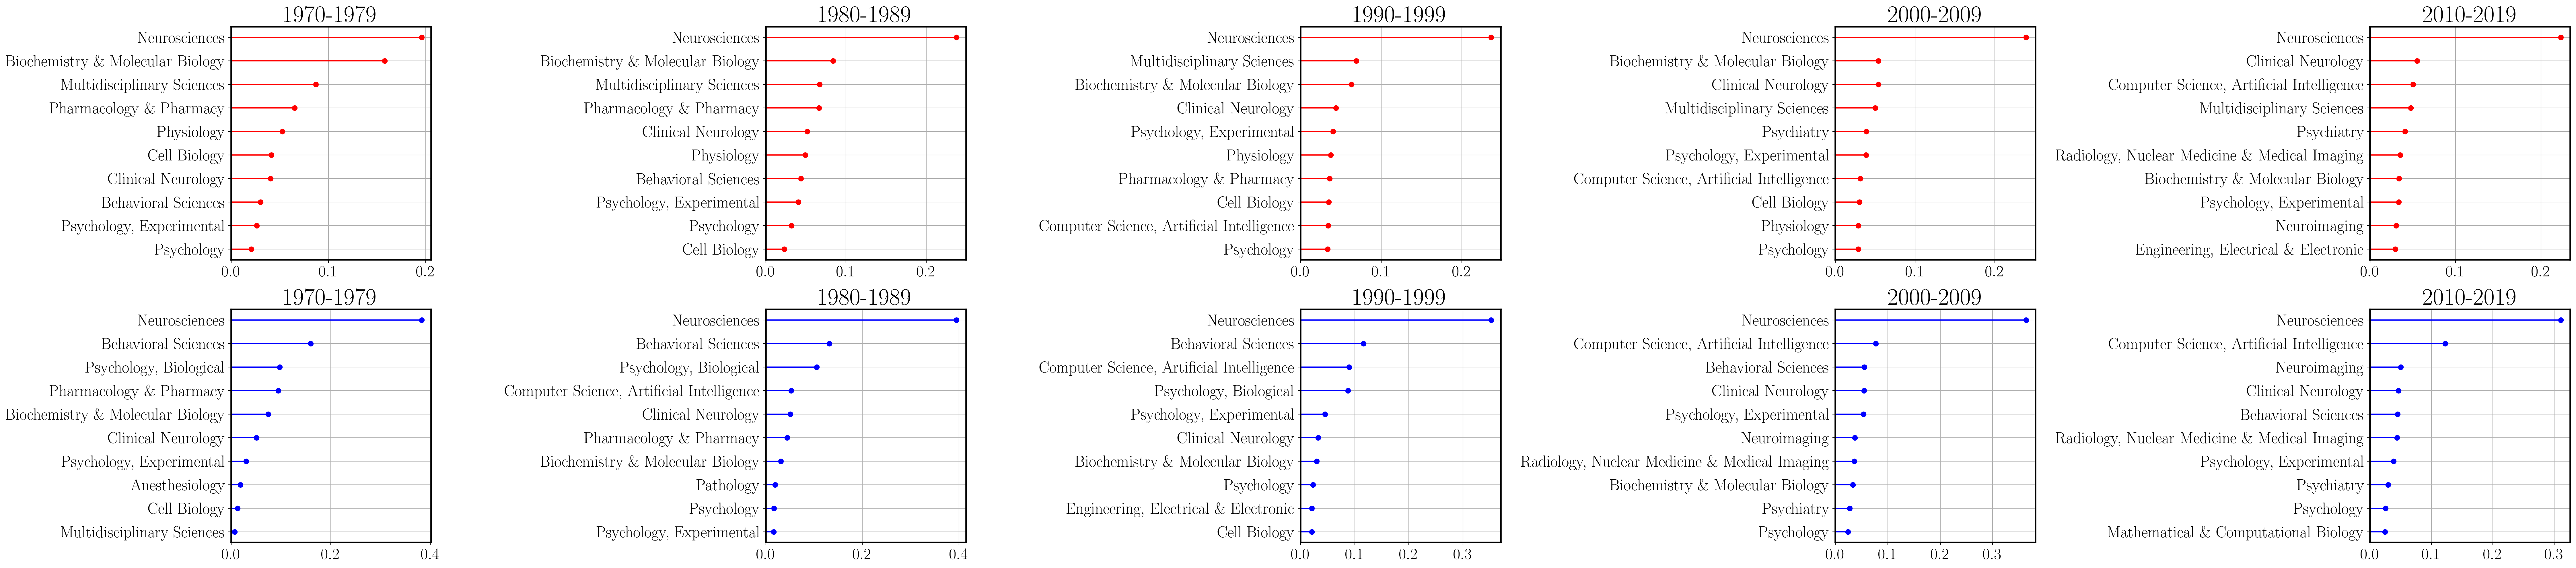

In [101]:
fig, axs = plt.subplots(2, len(NeuroAI_windowedDf_ref_prop), figsize=(45,10), dpi=200)
keys_ref = list(NeuroAI_windowedDf_ref_prop.keys())
for j in range(len(NeuroAI_windowedDf_ref_prop)):
    disciplines = list(NeuroAI_windowedDf_ref_prop[keys_ref[j]])[-10:]
    x = np.array([NeuroAI_windowedDf_ref_prop[keys_ref[j]][i] for i in disciplines])
    y = [i for i in range(10)]
    axs[0,j].hlines(y, 0, x, color='red')
    axs[0,j].plot(x, y, 'ro')
    axs[0,j].set_yticks(y, [i.replace('&', '\&') for i in disciplines])
    axs[0,j].set_xlim(left=0)
    axs[0,j].set_title(keys_ref[j], fontsize=30)
    axs[0,j].tick_params(labelsize=20)
    axs[0,j].grid()
    
keys_imp = list(NeuroAI_windowedDf_imp_prop.keys())
for j in range(len(NeuroAI_windowedDf_imp_prop)):
    disciplines = list(NeuroAI_windowedDf_imp_prop[keys_imp[j]])[-10:]
    x = np.array([NeuroAI_windowedDf_imp_prop[keys_imp[j]][i] for i in disciplines])
    y = [i for i in range(10)]
    axs[1,j].hlines(y, 0, x, color='blue')
    axs[1,j].plot(x, y, 'bo')
    axs[1,j].set_yticks(y, [i.replace('&', '\&') for i in disciplines])
    axs[1,j].set_xlim(left=0)
    axs[1,j].set_title(keys_imp[j], fontsize=30)
    axs[1,j].tick_params(labelsize=20)
    axs[1,j].grid()
plt.tight_layout()

## Subset of citations and impact of papers in $\mathcal{P}\cap \overline{AI}$

In [55]:
Neuro_disciplines_ref = {}
Neuro_disciplines_imp = {}

for y in set(NeuroPapers_subset['publicationYear']):
    ids = NeuroPapers_subset[NeuroPapers_subset['publicationYear']==y]['id']
        
    # ----------------REFERENCE--------------
        
    IDrefs = NeuroCN[NeuroCN['citing'].isin(ids)]['cited']
    IDrefs_counter = Counter(IDrefs)
    refs_data = NeuroPapers[NeuroPapers['id'].isin(IDrefs)]
    disciplines_ref = []
    for i in refs_data.index:
        d = eval(refs_data.loc[i,'wos_domains'])
        if d != -1:
            disciplines_ref += [j for j in d]*IDrefs_counter[refs_data.loc[i,'id']]
    Neuro_disciplines_ref[y] = dict(Counter(disciplines_ref))
        
    # ----------------IMPACT--------------
    
    citing_ids = NeuroCN[NeuroCN['cited'].isin(ids)]['citing']
    # filter with the period, keeping only papers that have been published 1 year after the main papers
    citing_ids = NeuroPapers[(NeuroPapers['id'].isin(citing_ids)) & (NeuroPapers['publicationYear']>=y) 
                               & (NeuroPapers['publicationYear'] <= y+1)]['id']
    IDimp = Counter(NeuroCN[NeuroCN['citing'].isin(citing_ids)]['citing'])
    disciplines_imp = []
    for i in IDimp.keys():
        d = eval(NeuroPapers[NeuroPapers['id']==i]['wos_domains'].values[0])
        if d != -1:
            disciplines_imp += [j for j in d]*IDimp[i]
    Neuro_disciplines_imp[y] = dict(Counter(disciplines_imp))
    
    print(y)

1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [56]:
with open(f'{path_output}Neuro_disciplines_ref.json', 'w', encoding='utf8') as bj:
    json.dump(Neuro_disciplines_ref,bj)
with open(f'{path_output}Neuro_disciplines_imp.json', 'w', encoding='utf8') as bj:
    json.dump(Neuro_disciplines_imp,bj)

In [59]:
# compute the ratio of citations toward (cited) or from (citing) each discipline at each year
Neuro_disciplines_ref_prop = {y:{k:Neuro_disciplines_ref[y][k]/sum(Neuro_disciplines_ref[y].values()) for k in sorted(Neuro_disciplines_ref[y], key=Neuro_disciplines_ref[y].get)} for y in Neuro_disciplines_ref.keys()}
Neuro_disciplines_imp_prop = {y:{k:Neuro_disciplines_imp[y][k]/sum(Neuro_disciplines_imp[y].values()) for k in sorted(Neuro_disciplines_imp[y], key=Neuro_disciplines_imp[y].get)} for y in Neuro_disciplines_imp.keys()}

In [60]:
df = pd.DataFrame({k: dict(Neuro_disciplines_ref[k]) for k in Neuro_disciplines_ref.keys()}).T.fillna(0).astype('int')
df.index = [int(i) for i in df.index]
df2 = pd.DataFrame({k: dict(Neuro_disciplines_imp[k]) for k in Neuro_disciplines_imp.keys()}).T.fillna(0).astype('int')
df2.index = [int(i) for i in df2.index]

In [61]:
# compute aggregated citation counts over 10 years
y = 1970
step = 10
Neuro_windowedDf_ref = {}
Neuro_windowedDf_imp = {}
while y < 2019:
    Neuro_windowedDf_ref[f'{y}-{y+step-1}'] = dict(df.loc[range(y,y+step)].sum())
    Neuro_windowedDf_imp[f'{y}-{y+step-1}'] = dict(df2.loc[range(y,y+step)].sum())
    y += step
    print(y)

1980
1990
2000
2010
2020


In [62]:
# compute also the ratio of citations toward (cited) or from (citing) each discipline at each decade
Neuro_windowedDf_ref_prop = {y:{k:Neuro_windowedDf_ref[y][k]/sum(Neuro_windowedDf_ref[y].values()) for k in sorted(Neuro_windowedDf_ref[y], key=Neuro_windowedDf_ref[y].get)} for y in Neuro_windowedDf_ref.keys()}
Neuro_windowedDf_imp_prop = {y:{k:Neuro_windowedDf_imp[y][k]/sum(Neuro_windowedDf_imp[y].values()) for k in sorted(Neuro_windowedDf_imp[y], key=Neuro_windowedDf_imp[y].get)} for y in Neuro_windowedDf_imp.keys()}

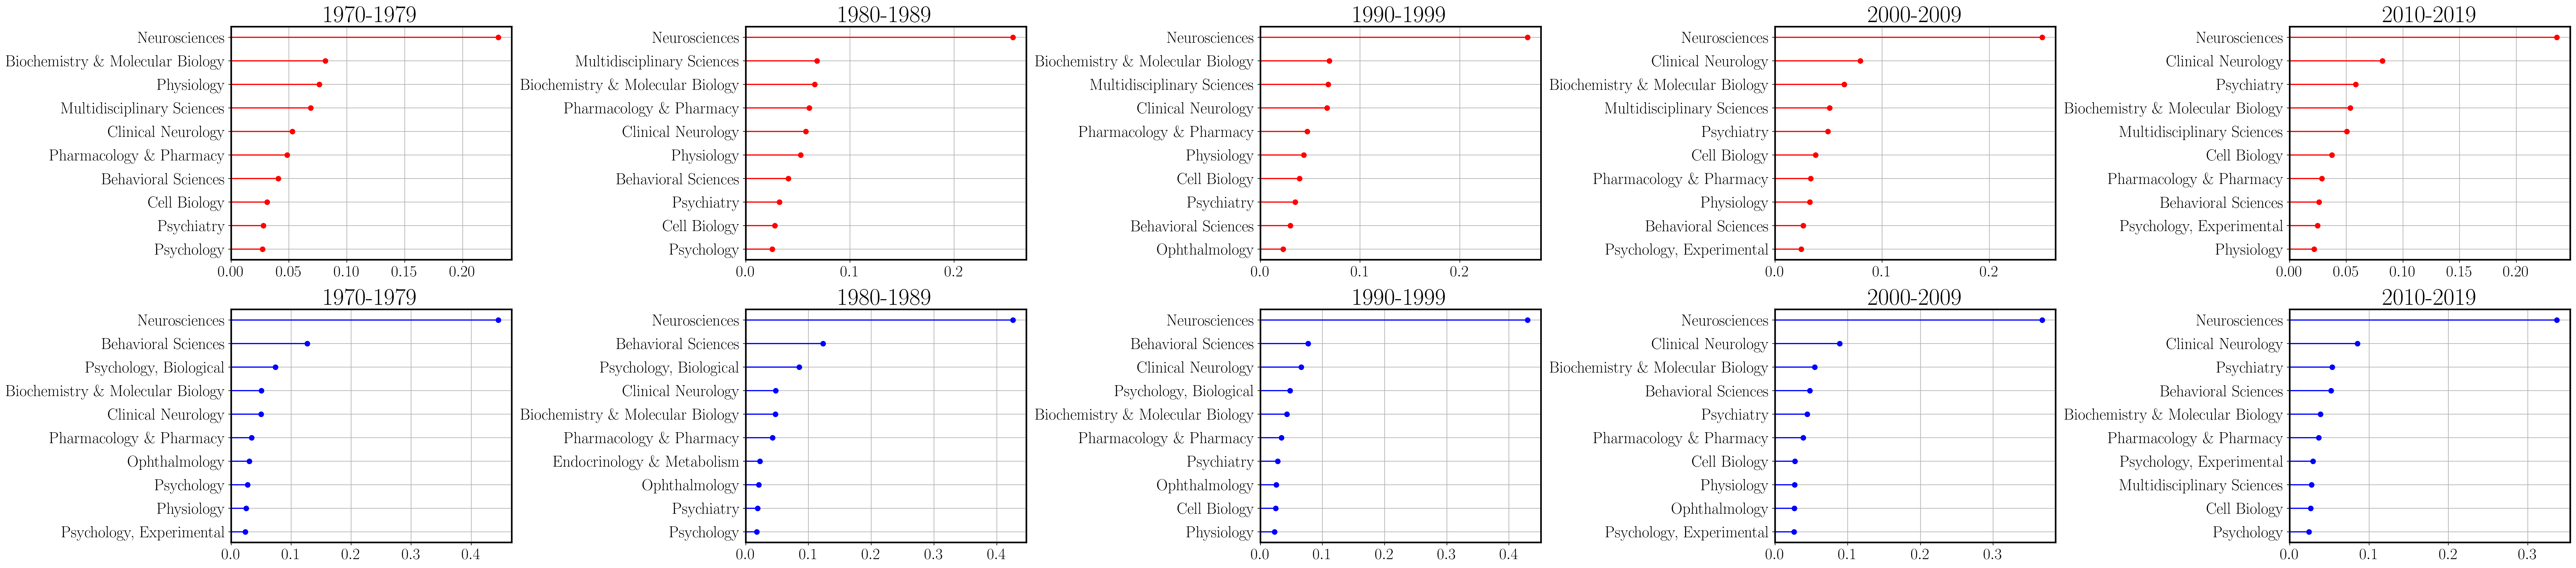

In [65]:
fig, axs = plt.subplots(2, len(Neuro_windowedDf_ref_prop), figsize=(45,10), dpi=200)
keys_ref = list(Neuro_windowedDf_ref_prop.keys())
for j in range(len(Neuro_windowedDf_ref_prop)):
    disciplines = list(Neuro_windowedDf_ref_prop[keys_ref[j]])[-10:]
    x = np.array([Neuro_windowedDf_ref_prop[keys_ref[j]][i] for i in disciplines])
    y = [i for i in range(10)]
    axs[0,j].hlines(y, 0, x, color='red')
    axs[0,j].plot(x, y, 'ro')
    axs[0,j].set_yticks(y, [i.replace('&', '\&') for i in disciplines])
    axs[0,j].set_xlim(left=0)
    axs[0,j].set_title(keys_ref[j], fontsize=30)
    axs[0,j].tick_params(labelsize=20)
    axs[0,j].grid()
    
keys_imp = list(Neuro_windowedDf_imp_prop.keys())
for j in range(len(Neuro_windowedDf_imp_prop)):
    disciplines = list(Neuro_windowedDf_imp_prop[keys_imp[j]])[-10:]
    x = np.array([Neuro_windowedDf_imp_prop[keys_imp[j]][i] for i in disciplines])
    y = [i for i in range(10)]
    axs[1,j].hlines(y, 0, x, color='blue')
    axs[1,j].plot(x, y, 'bo')
    axs[1,j].set_yticks(y, [i.replace('&', '\&') for i in disciplines])
    axs[1,j].set_xlim(left=0)
    axs[1,j].set_title(keys_imp[j], fontsize=30)
    axs[1,j].tick_params(labelsize=20)
    axs[1,j].grid()
plt.tight_layout()

## Get ranking for aggregated disciplines (first level of WOS classification)

Some WOS disciplines previously used could have an additional subfield after a comma, eg. "Computer Science, Artificial Intelligence (CS.AI)" and "Computer Science, Cybernetics (CS.Cy)". We thus aggregate such disciplines at their first level, eg. "Computer Science" in the previous example, and sum their respective contributions. For example, if CS.AI has 5 citations and CS.Cy has 7 citations, their corresponding aggregated/first level discipline would be Computer Science with 12 citations.

In [57]:
with open(f'{path_output}NeuroAI_disciplines_ref.json', 'r', encoding='utf8') as bj:
    NeuroAI_disciplines_ref = json.load(bj)
with open(f'{path_output}NeuroAI_disciplines_imp.json', 'r', encoding='utf8') as bj:
    NeuroAI_disciplines_imp = json.load(bj)

In [ ]:
with open(f'{path_output}Neuro_disciplines_ref.json', 'r', encoding='utf8') as bj:
    Neuro_disciplines_ref = json.load(bj)
with open(f'{path_output}Neuro_disciplines_imp.json', 'r', encoding='utf8') as bj:
    Neuro_disciplines_imp = json.load(bj)

In [66]:
def discipline_aggregation(citation_count):
    list_keys = [i.split(', ') for i in citation_count.keys()]
    g = {}
    while len(list_keys) > 0:
        main_disc = list_keys[0][0]
        new_count = citation_count[', '.join(list_keys[0])]
        to_remove = [list_keys[0]]
        for d in list_keys[1:]:
            if d[0] == main_disc:
                new_count += citation_count[', '.join(d)]
                to_remove.append(d)
        g[main_disc] = new_count
        for k in to_remove:
            list_keys.remove(k)
    return {k:g[k] for k in sorted(g, key=g.get)}

def aggregation(data):
    g = {}
    for y in set(data.keys()):
        g[y] = discipline_aggregation(data[y])
    return g

In [67]:
def get_ranking_with_exaequo_one_period(d):
    ranking = []
    k = 1
    for i in reversed(Counter(d.values()).values()):
        ranking = [k]*int(i) + ranking
        k += i
    return ranking

def get_rankings_with_exaequo(citation_counts):
    ranking = {}
    for k in citation_counts.keys():
        r = get_ranking_with_exaequo_one_period(citation_counts[k])
        g = {}
        l = 0
        for d in citation_counts[k].keys():
            g[d] = r[l]
            l += 1
        ranking[k] = g
    return ranking

In [73]:
# aggregate all count made before
# Neuro
Neuro_disciplines_ref_agg = aggregation(Neuro_disciplines_ref)
Neuro_disciplines_imp_agg = aggregation(Neuro_disciplines_imp)
Neuro_disciplines_ref_agg_prop = {y:{k:Neuro_disciplines_ref_agg[y][k]/sum(Neuro_disciplines_ref_agg[y].values()) for k in sorted(Neuro_disciplines_ref_agg[y], key=Neuro_disciplines_ref_agg[y].get)} for y in Neuro_disciplines_ref_agg.keys()}
Neuro_disciplines_imp_agg_prop = {y:{k:Neuro_disciplines_imp_agg[y][k]/sum(Neuro_disciplines_imp_agg[y].values()) for k in sorted(Neuro_disciplines_imp_agg[y], key=Neuro_disciplines_imp_agg[y].get)} for y in Neuro_disciplines_imp_agg.keys()}

Neuro_windowedDf_ref_agg = aggregation(Neuro_windowedDf_ref)
Neuro_windowedDf_imp_agg = aggregation(Neuro_windowedDf_imp)
Neuro_windowedDf_ref_agg_prop = {y:{k:Neuro_windowedDf_ref_agg[y][k]/sum(Neuro_windowedDf_ref_agg[y].values()) for k in Neuro_windowedDf_ref_agg[y]} for y in Neuro_windowedDf_ref_agg.keys()}
Neuro_windowedDf_imp_agg_prop = {y:{k:Neuro_windowedDf_imp_agg[y][k]/sum(Neuro_windowedDf_imp_agg[y].values()) for k in Neuro_windowedDf_imp_agg[y]} for y in Neuro_windowedDf_imp_agg.keys()}

# NeuroAI
NeuroAI_disciplines_ref_agg = aggregation(NeuroAI_disciplines_ref)
NeuroAI_disciplines_imp_agg = aggregation(NeuroAI_disciplines_imp)
NeuroAI_disciplines_ref_agg_prop = {y:{k:NeuroAI_disciplines_ref_agg[y][k]/sum(NeuroAI_disciplines_ref_agg[y].values()) for k in sorted(NeuroAI_disciplines_ref_agg[y], key=NeuroAI_disciplines_ref_agg[y].get)} for y in NeuroAI_disciplines_ref_agg.keys()}
NeuroAI_disciplines_imp_agg_prop = {y:{k:NeuroAI_disciplines_imp_agg[y][k]/sum(NeuroAI_disciplines_imp_agg[y].values()) for k in sorted(NeuroAI_disciplines_imp_agg[y], key=NeuroAI_disciplines_imp_agg[y].get)} for y in NeuroAI_disciplines_imp_agg.keys()}

NeuroAI_windowedDf_ref_agg = aggregation(NeuroAI_windowedDf_ref)
NeuroAI_windowedDf_imp_agg = aggregation(NeuroAI_windowedDf_imp)
NeuroAI_windowedDf_ref_agg_prop = {y:{k:NeuroAI_windowedDf_ref_agg[y][k]/sum(NeuroAI_windowedDf_ref_agg[y].values()) for k in NeuroAI_windowedDf_ref_agg[y]} for y in NeuroAI_windowedDf_ref_agg.keys()}
NeuroAI_windowedDf_imp_agg_prop = {y:{k:NeuroAI_windowedDf_imp_agg[y][k]/sum(NeuroAI_windowedDf_imp_agg[y].values()) for k in NeuroAI_windowedDf_imp_agg[y]} for y in NeuroAI_windowedDf_imp_agg.keys()}

In [74]:
# compute the windowed rankings (be careful to ex-aequo!!!)
ranking_ref_agg_Neuro = get_rankings_with_exaequo(Neuro_windowedDf_ref_agg_prop)
ranking_imp_agg_Neuro = get_rankings_with_exaequo(Neuro_windowedDf_imp_agg_prop)
ranking_ref_agg_NeuroAI = get_rankings_with_exaequo(NeuroAI_windowedDf_ref_agg_prop)
ranking_imp_agg_NeuroAI = get_rankings_with_exaequo(NeuroAI_windowedDf_imp_agg_prop)

In [75]:
# recompute the rankings matrix
ranking_ref_agg = (pd.concat([pd.DataFrame(ranking_ref_agg_Neuro), pd.DataFrame(ranking_ref_agg_NeuroAI)])
   .stack()
   .groupby(level=[0,1])
   .apply(tuple)
   .unstack())
ranking_imp_agg = (pd.concat([pd.DataFrame(ranking_imp_agg_Neuro), pd.DataFrame(ranking_imp_agg_NeuroAI)])
   .stack()
   .groupby(level=[0,1])
   .apply(tuple)
   .unstack())

# Comparison of ranking for both sets and 10-years' temporal periods

In [97]:
def plot_2D_ranking_diagram(direction, # 'ref' or 'imp'
                            is_agg, # bool
                            ranking_table,
                            Neuro_citation_counts, # to compute the size of the point in the 2D map
                            Neuro_citation_counts_prop, # idem
                            NeuroAI_citation_counts, # idem
                            NeuroAI_citation_counts_prop, # idem
                            tolerance_around_diagonal, # size of the zone above and below the line y=x
                            maxprop_discipline_to_display, # we want only for each point the points whose size is higher than the max size in the data
                            axis_lim,
                            rank_lim_showtext, # maximum ranks for showing the disciplines on the plot (tuple, one rank for each axis)
                            is_zoom,
                            zoom,
                            tolerance_around_diagonal_zoom,
                            figsize,
                            size_axisLabel,
                            size_ticksLabel,
                            print_disciplines_labels, # say if we want to print the text
                            size_disciplineLabel,
                            resolution_size_point, # increase the size of the points in the plot
                            wos_abb,
                            save_folder):

    fig, axs = plt.subplots(1, len(ranking_table.columns), figsize=figsize)
    n = 5
    plt.rc('axes', linewidth=n)
    ticksSizeMajor = 20
    ticksSizeMinor = 5
    ticksWidth = n
    sizeTitle = 120
    j = 0
    
    cmap = plt.cm.tab20.colors
    blue = cmap[0]
    purple = cmap[8]
    grey = cmap[14]
    
    din = set()
    dout = set()
    dout2 = []

    for period in ranking_table.columns:

        disciplines = [i for i in ranking_table.index if len(ranking_table[period][i]) == 2]
        if is_agg == False:
            disciplines_agg = [i.split(',')[0] for i in ranking_table.index if len(ranking_table[period][i]) == 2]
        
        # get coordinates of the points
        x = [ranking_table[period][i][0] for i in ranking_table.index if len(ranking_table[period][i]) == 2]
        y = [ranking_table[period][i][1] for i in ranking_table.index if len(ranking_table[period][i]) == 2]
        xy = [ranking_table[period][i] for i in ranking_table.index if len(ranking_table[period][i]) == 2]
        
        # get the size of each point: the weighted mean of the two frequencies along each axis (Neuro and NeuroAI)
        s = [(Neuro_citation_counts[period][i]*Neuro_citation_counts_prop[period][i]
              +NeuroAI_citation_counts[period][i]*NeuroAI_citation_counts_prop[period][i])
             /(Neuro_citation_counts_prop[period][i]+NeuroAI_citation_counts_prop[period][i])
            for i in ranking_table.index if len(ranking_table[period][i]) == 2]
        # convert it to square root in order to flatten the values and the variance, better than log that flattens stronger
        s_sqrt = [np.sqrt(i) if i != None else 0 for i in s]

        # select the indices of the disciplines we want to show
        if is_zoom:
            x_zoom = np.where(np.array(x) <= zoom)[0]
            y_zoom = np.where(np.array(y) <= zoom)[0]
            ind2show = set(x_zoom) & set(y_zoom)
            # set the limit of the plot
            xlim, ylim = zoom, zoom
            pos, ticks = np.arange(0,zoom+1,10), np.arange(0,zoom+1,10)
            # set the tolerance for the zoom
            t = tolerance_around_diagonal_zoom
            # for the final file name
            z = 'zoom'
        else:
            # selection based on the size here
            ind2show = np.where(np.array(s_sqrt) >= maxprop_discipline_to_display*max(i for i in s_sqrt if not np.isnan(i)))[0]
            xlim, ylim = axis_lim, axis_lim
            pos, ticks = np.arange(0,axis_lim+1,50), np.arange(0,axis_lim+1,50)
            t = tolerance_around_diagonal
            z = ''

        # distinguish the disciplines that are in the tolerance zone from those at the bording zone or outside
        # search the indices within the vector of size s
        ind2show_inzone = []
        ind2show_outzone_bottom = []
        ind2show_outzone_top = []
        for i in ind2show:
            if (y[i] >= x[i]-t) & (y[i] <= x[i]+t):
                ind2show_inzone.append(i)
            elif y[i] < x[i]-t:
                ind2show_outzone_bottom.append(i)
            elif y[i] > x[i]+t:
                ind2show_outzone_top.append(i)    
        colors_in = [grey]*len(ind2show_inzone)
        disciplines_in = {disciplines[i]: np.where(np.array(list(Neuro_citation_counts_prop[period].keys()))==disciplines[i])[0][0]
                               for i in ind2show_inzone}
        disciplines_in = [d for d in {k:disciplines_in[k] 
                                for k in sorted(disciplines_in, key=disciplines_in.get, reverse=True)}.keys()][:20]
        if period == '1970-1979':
            din = set(disciplines_in)
        else:
            din &= set(disciplines_in)
        colors_out_top = [blue]*len(ind2show_outzone_top)
        disciplines_out_top = {disciplines[i]: np.where(np.array(list(Neuro_citation_counts_prop[period].keys()))==disciplines[i])[0][0]
                               for i in ind2show_outzone_top}
        disciplines_out_top = [d for d in {k:disciplines_out_top[k] 
                                for k in sorted(disciplines_out_top, key=disciplines_out_top.get, reverse=True)}.keys()][:20]
        colors_out_bottom = [purple]*len(ind2show_outzone_bottom)
        disciplines_out_bottom = {disciplines[i]: np.where(np.array(list(NeuroAI_citation_counts_prop[period].keys()))==disciplines[i])[0][0]
                                  for i in ind2show_outzone_bottom}
        disciplines_out_bottom = [d for d in {k:disciplines_out_bottom[k]
                                  for k in sorted(disciplines_out_bottom, key=disciplines_out_bottom.get, reverse=True)}.keys()][:20]
        print(f'in_zone: {len(ind2show_inzone)}\n', disciplines_in)
        print(f'out_top: {len(ind2show_outzone_top)}\n', disciplines_out_top)
        print(f'out_bottom: {len(ind2show_outzone_bottom)}\n', disciplines_out_bottom)
        dout |= set(disciplines_out_bottom)|set(disciplines_out_top)

        # plot the line x=y and the delimiting zone of tolerance
        axs[j].plot(range(0,xlim+1), range(0,ylim+1), '--', color='black')
        #axs[0,j].plot(range(0,200), [x-tolerance for x in range(0,200)], '--', color='red')
        #axs[0,j].plot(range(0,200), [x+tolerance for x in range(0,200)], '--', color='red')

        # plot only the points that have both coordinates in Neuro and NeuroAI,
        # and that appears at least once in both set Neuro and NeuroAI
        axs[j].scatter([x[i] for i in ind2show_inzone], 
                       [y[i] for i in ind2show_inzone], 
                       np.array([s_sqrt[i] for i in ind2show_inzone])*resolution_size_point,
                       c=colors_in, 
                       facecolors='none', 
                       edgecolors='none',
                       alpha=0.2)
        axs[j].scatter([x[i] for i in ind2show_outzone_top], 
                       [y[i] for i in ind2show_outzone_top], 
                       np.array([s_sqrt[i] for i in ind2show_outzone_top])*resolution_size_point, 
                       facecolors=colors_out_top, #'none', 
                       edgecolors= 'none',
                       #linewidth=10,
                       alpha=0.2)
        axs[j].scatter([x[i] for i in ind2show_outzone_bottom], 
                       [y[i] for i in ind2show_outzone_bottom], 
                       np.array([s_sqrt[i] for i in ind2show_outzone_bottom])*resolution_size_point,
                       facecolors=colors_out_bottom, #'none', 
                       edgecolors='none',
                       #linewidth=10,
                       alpha=0.3)
        axs[j].set_xlim(left=0)
        axs[j].set_ylim(bottom=0)
        axs[j].set_title(period, fontsize=sizeTitle)
        axs[j].tick_params(labelsize=size_ticksLabel, length=ticksSizeMajor, width=ticksWidth)
        axs[j].set_xlabel(r'$r_{\mathcal{P}\cap\overline{AI}}$', fontsize=size_axisLabel)
        #axs[j].set_xscale('log')
        #axs[j].set_yscale('log')
        axs[j].set_xlim(0,xlim)
        axs[j].set_ylim(0,ylim)
        axs[j].set_xticks(pos, ticks)
        axs[j].set_yticks(pos, ticks)
        if j == 0:
            axs[j].set_ylabel(r'$r_{\mathcal{P}\cap AI}$', fontsize=size_axisLabel)
        
        # if we want to print some labels of disciplines
        if print_disciplines_labels:
            if is_zoom:
                # print all labels in zoom
                if j == 0:
                    for i in ind2show:
                        axs[j].text(x[i], y[i], disciplines[i].replace('&','\&'), fontsize=size_disciplineLabel, clip_on=True)
                else:
                    texts = []
                    for i in ind2show:
                        texts.append(axs[j].text(x[i], y[i], disciplines[i].replace('&','\&'), fontsize=size_disciplineLabel, clip_on=True))
                    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, autoalign='y')
            else: # print only the labels outside the tolerance zone
                axs[j].set_title(period, fontsize=size_axisLabel)
                texts = []
                # print only the labels that are in the defined ranking limit:
                # first zoom in the ranking limit, second select the 100 first in the bottom and the 100 first in the top zoneS
                for i in ind2show_outzone_bottom:
                    if (x[i] < rank_lim_showtext[0]) & (y[i] < rank_lim_showtext[1]):
                        dout2.append(disciplines[i])
                        texts.append(axs[j].text(x[i], y[i], wos_abb[disciplines[i]], 
                                                 fontsize=size_disciplineLabel,
                                                 fontweight='extra bold',
                                                 clip_on=True))
                for i in ind2show_outzone_top:
                    if (x[i] < rank_lim_showtext[1]) & (y[i] < rank_lim_showtext[0]):
                        dout2.append(disciplines[i])
                        texts.append(axs[j].text(x[i], y[i],wos_abb[disciplines[i]], 
                                                 fontsize=size_disciplineLabel,
                                                 fontweight='extra bold',
                                                 clip_on=True))
                #adjust_text(texts, only_move={'points':'y', 'texts':'y'}, autoalign='y')
        
        j += 1
    # print(din)
    # print(len(din))
    print(dout)
    print(set(dout2))
    plt.tight_layout()
    if is_agg == True:
        filename = f'rankings_agg_{direction}_{z}{zoom}'
    else:
        filename = f'rankings_{direction}_{z}{zoom}'
    plt.savefig(f'{save_folder}/{filename}.svg', format='svg', bbox_inches='tight')

# Vizualisations of the 2D maps of rankings in $\mathcal{P}\cap AI$ and $\mathcal{P}\cap\overline{AI}$

- Maximum ranking in the two datasets: 100
- Tolerance zone around the diagonal: 10

### References

/tmp/ipykernel_276036/261068546.py:52: RuntimeWarning: invalid value encountered in double_scalars
  s = [(Neuro_citation_counts[period][i]*Neuro_citation_counts_prop[period][i]


in_zone: 57
 ['Neurosciences', 'Psychology', 'Biochemistry & Molecular Biology', 'Physiology', 'Behavioral Sciences', 'Clinical Neurology', 'Multidisciplinary Sciences', 'Pharmacology & Pharmacy', 'Ophthalmology', 'Cell Biology', 'Psychiatry', 'Medicine', 'Zoology', 'Pathology', 'Endocrinology & Metabolism', 'Chemistry', 'Biology', 'Biophysics', 'Surgery', 'Anatomy & Morphology']
out_top: 23
 ['Peripheral Vascular Diseases', 'Ecology', 'Optics', 'Rehabilitation', 'Cardiac & Cardiovascular System', 'Sport Sciences', 'Hematology', 'Physics', 'Toxicology', 'Public', 'Medical Laboratory Technology', 'Microscopy', 'Marine & Freshwater Biology', 'Reproductive Biology', 'Gastroenterology & Hepatology', 'Food Science & Technology', 'Agriculture', 'Ornithology', 'Astronomy & Astrophysics', 'Dermatology']
out_bottom: 41
 ['Computer Science', 'Otorhinolaryngology', 'Engineering', 'Mathematics', 'Ergonomics', 'Social Sciences', 'Radiology', 'Biotechnology & Applied Microbiology', 'Statistics & Pro

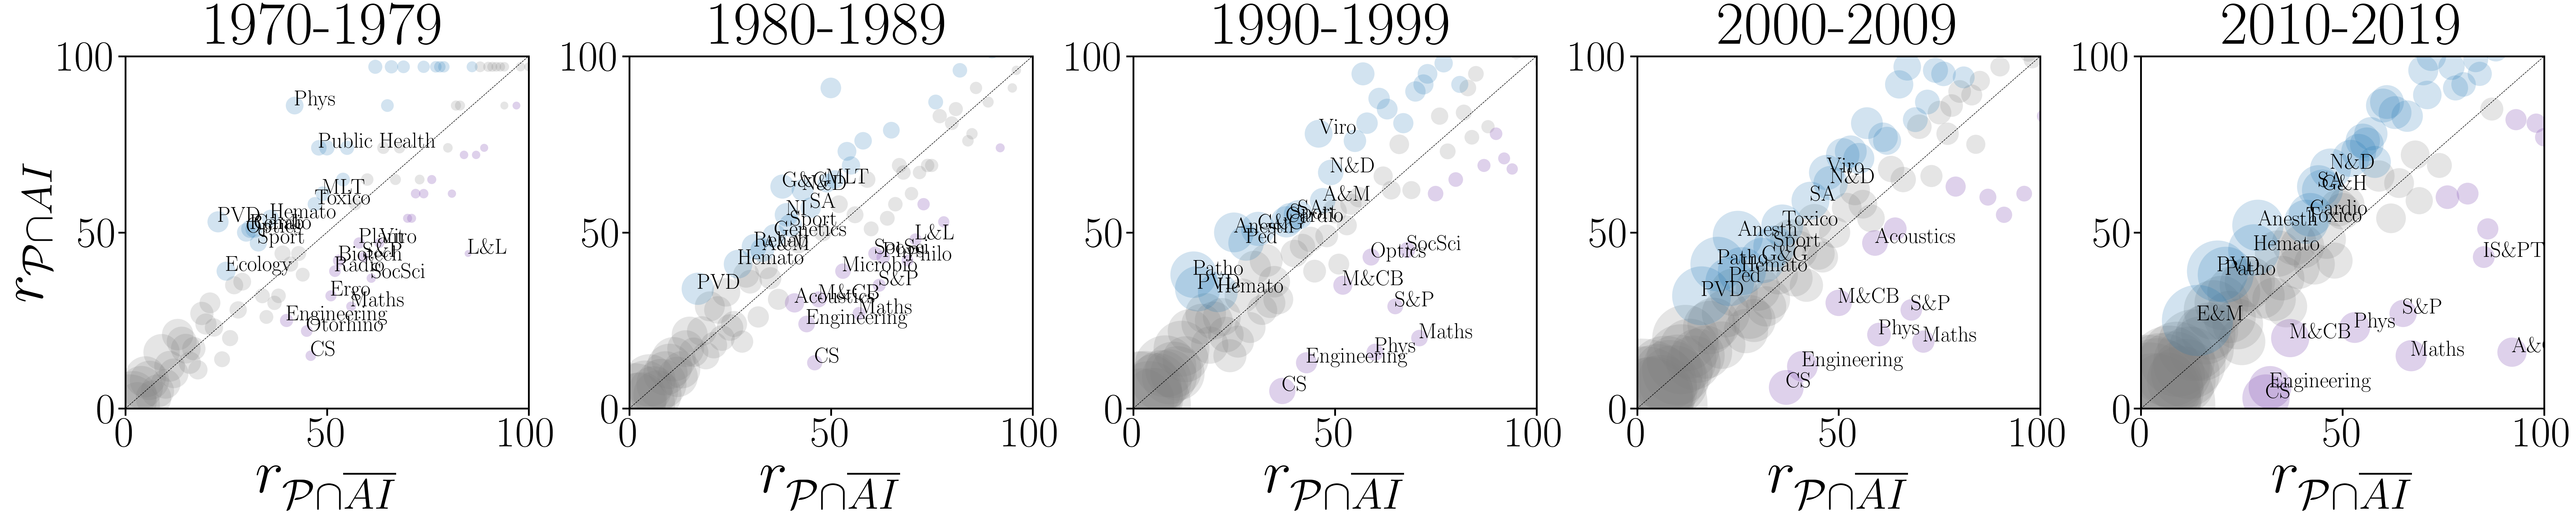

In [144]:
plot_2D_ranking_diagram(direction='ref', # 'ref' or 'imp'
                            is_agg=True, # bool
                            ranking_table=ranking_ref_agg,
                            Neuro_citation_counts=Neuro_windowedDf_ref_agg,
                            Neuro_citation_counts_prop=Neuro_windowedDf_ref_agg_prop,
                            NeuroAI_citation_counts=NeuroAI_windowedDf_ref_agg,
                            NeuroAI_citation_counts_prop=NeuroAI_windowedDf_ref_agg_prop,
                            tolerance_around_diagonal=10,
                            maxprop_discipline_to_display=0.01, # we want only for each point the points whose size is higher than 1% of the max size in the data
                            rank_lim_showtext=(100,50),
                            axis_lim=100,
                            is_zoom=False,
                            zoom=100,
                            tolerance_around_diagonal_zoom=10,
                            figsize=(100,20),
                            size_axisLabel=170,
                            size_ticksLabel=120,                            
                            print_disciplines_labels=True,
                            size_disciplineLabel=60,
                            resolution_size_point=60, # increase the size of the points in the plot
                            wos_abb=wos_abb,
                            save_folder=path_output)

/tmp/ipykernel_66810/2468214021.py:54: RuntimeWarning: invalid value encountered in double_scalars
  s = [(Neuro_citation_counts[period][i]*Neuro_citation_counts_prop[period][i]


in_zone: 58
 ['Neurosciences', 'Psychology', 'Biochemistry & Molecular Biology', 'Physiology', 'Multidisciplinary Sciences', 'Clinical Neurology', 'Pharmacology & Pharmacy', 'Behavioral Sciences', 'Cell Biology', 'Medicine', 'Psychiatry', 'Ophthalmology', 'Endocrinology & Metabolism', 'Zoology', 'Pathology', 'Chemistry', 'Biology', 'Biophysics', 'Surgery', 'Anatomy & Morphology']
out_top: 23
 ['Ecology', 'Peripheral Vascular Diseases', 'Optics', 'Cardiac & Cardiovascular System', 'Rehabilitation', 'Hematology', 'Sport Sciences', 'Physics', 'Toxicology', 'Public', 'Medical Laboratory Technology', 'Microscopy', 'Marine & Freshwater Biology', 'Reproductive Biology', 'Gastroenterology & Hepatology', 'Agriculture', 'Food Science & Technology', 'Ornithology', 'Astronomy & Astrophysics', 'Dermatology']
out_bottom: 55
 ['Computer Science', 'Otorhinolaryngology', 'Engineering', 'Mathematics', 'Ergonomics', 'Anesthesiology', 'Social Sciences', 'Radiology', 'Statistics & Probability', 'Language &

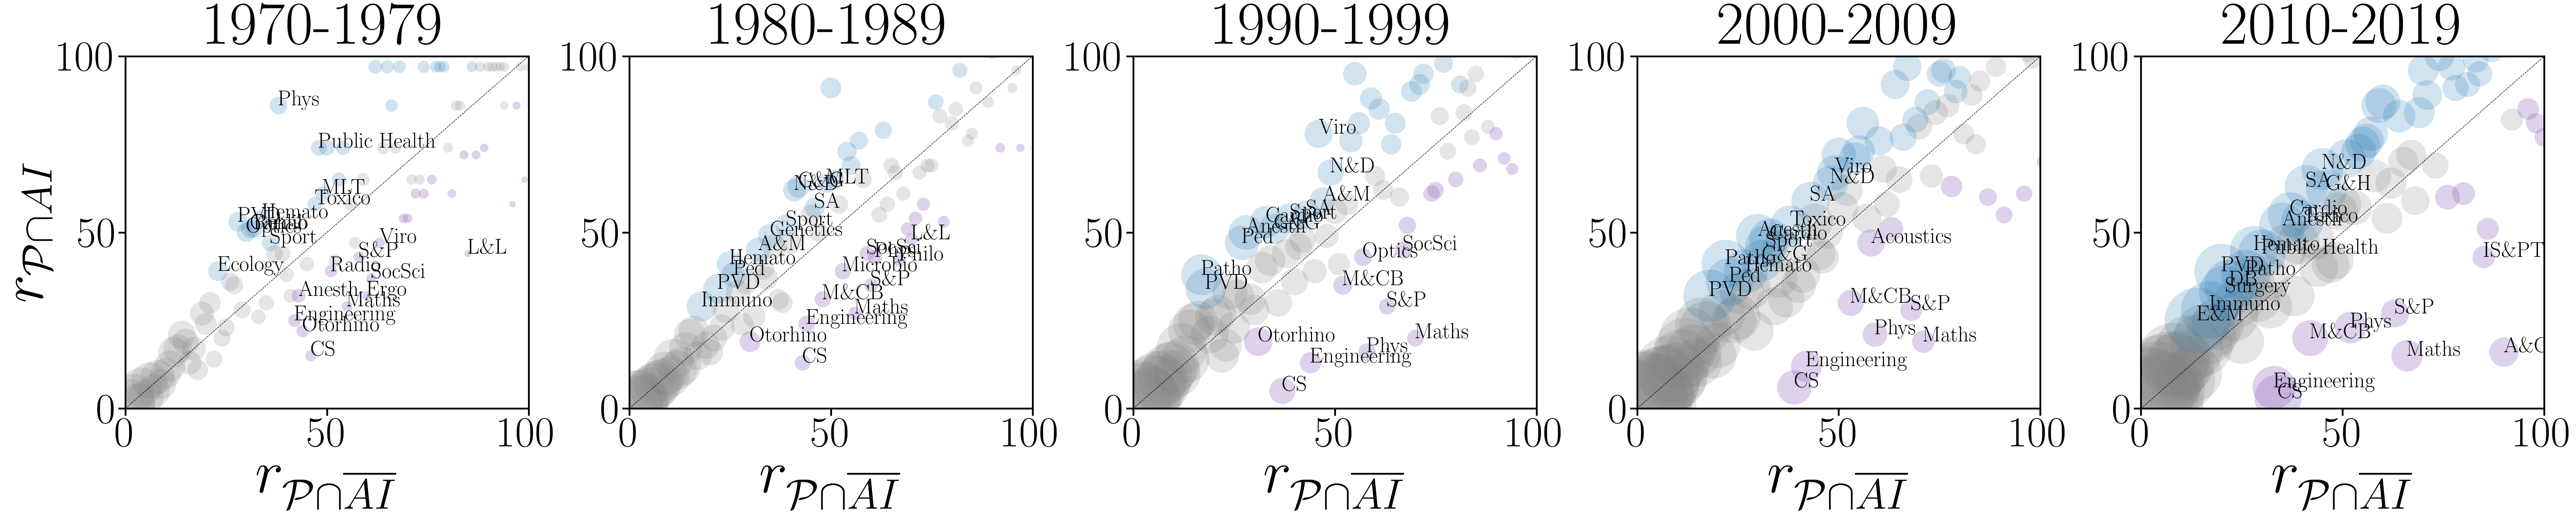

In [98]:
plot_2D_ranking_diagram(direction='ref', # 'ref' or 'imp'
                            is_agg=True, # bool
                            ranking_table=ranking_ref_agg,
                            Neuro_citation_counts=Neuro_windowedDf_ref_agg,
                            Neuro_citation_counts_prop=Neuro_windowedDf_ref_agg_prop,
                            NeuroAI_citation_counts=NeuroAI_windowedDf_ref_agg,
                            NeuroAI_citation_counts_prop=NeuroAI_windowedDf_ref_agg_prop,
                            tolerance_around_diagonal=10,
                            maxprop_discipline_to_display=0.01, # we want only for each point the points whose size is higher than 1% of the max size in the data
                            rank_lim_showtext=(100,50),
                            axis_lim=100,
                            is_zoom=False,
                            zoom=100,
                            tolerance_around_diagonal_zoom=10,
                            figsize=(100,20),
                            size_axisLabel=170,
                            size_ticksLabel=120,                            
                            print_disciplines_labels=True,
                            size_disciplineLabel=60,
                            resolution_size_point=60, # increase the size of the points in the plot
                            wos_abb=wos_abb,
                            save_folder=path_output)

### Impact

/tmp/ipykernel_276036/261068546.py:52: RuntimeWarning: invalid value encountered in double_scalars
  s = [(Neuro_citation_counts[period][i]*Neuro_citation_counts_prop[period][i]


in_zone: 35
 ['Neurosciences', 'Behavioral Sciences', 'Psychology', 'Biochemistry & Molecular Biology', 'Pharmacology & Pharmacy', 'Clinical Neurology', 'Multidisciplinary Sciences', 'Physiology', 'Cell Biology', 'Ophthalmology', 'Anesthesiology', 'Zoology', 'Audiology & Speech-Language Pathology', 'Chemistry', 'Otorhinolaryngology', 'Biology', 'Medicine', 'Psychiatry', 'Endocrinology & Metabolism', 'Linguistics']
out_top: 3
 ['Genetics & Heredity', 'Entomology', 'Anthropology']
out_bottom: 4
 ['Microbiology', 'Biotechnology & Applied Microbiology', 'Dentistry', 'Immunology']
in_zone: 37
 ['Neurosciences', 'Behavioral Sciences', 'Psychology', 'Biochemistry & Molecular Biology', 'Pharmacology & Pharmacy', 'Clinical Neurology', 'Endocrinology & Metabolism', 'Audiology & Speech-Language Pathology', 'Computer Science', 'Ophthalmology', 'Otorhinolaryngology', 'Psychiatry', 'Cell Biology', 'Multidisciplinary Sciences', 'Hematology', 'Pathology', 'Physiology', 'Chemistry', 'Developmental Biol

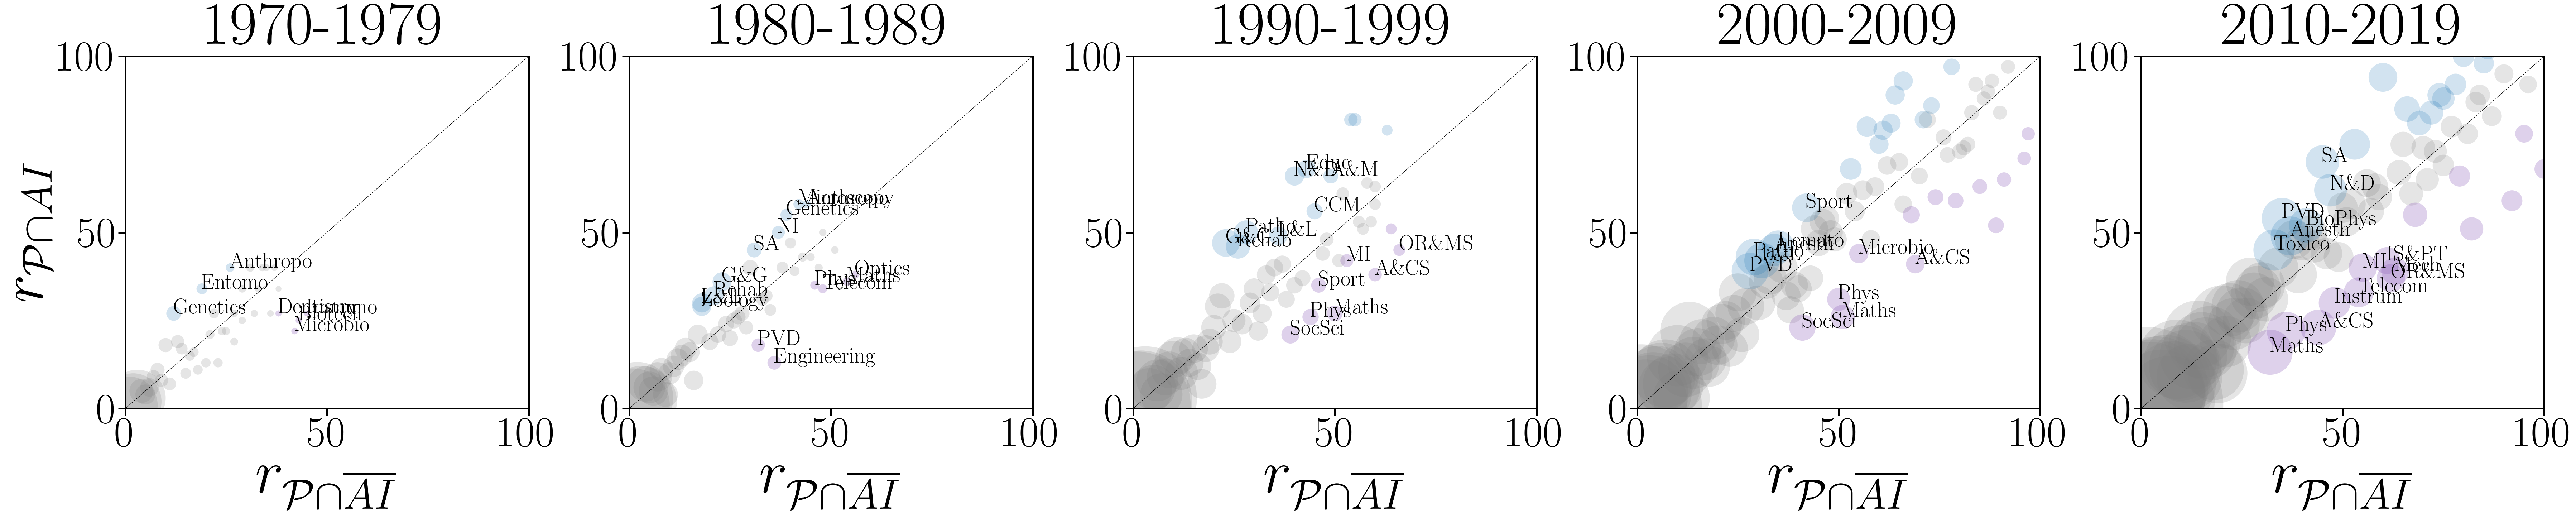

In [146]:
plot_2D_ranking_diagram(direction='imp', # 'imp' or 'imp'
                            is_agg=True, # bool
                            ranking_table=ranking_imp_agg,
                            Neuro_citation_counts=Neuro_windowedDf_imp_agg,
                            Neuro_citation_counts_prop=Neuro_windowedDf_imp_agg_prop,
                            NeuroAI_citation_counts=NeuroAI_windowedDf_imp_agg,
                            NeuroAI_citation_counts_prop=NeuroAI_windowedDf_imp_agg_prop,
                            tolerance_around_diagonal=10,
                            maxprop_discipline_to_display=0.01, # we want only for each point the points whose size is higher than the max size in the data
                            rank_lim_showtext=(100,50),
                            axis_lim=100,
                            is_zoom=False,
                            zoom=100,
                            tolerance_around_diagonal_zoom=10,
                            figsize=(100,20),
                            size_axisLabel=170,
                            size_ticksLabel=120,                            
                            print_disciplines_labels=True,
                            size_disciplineLabel=60,
                            resolution_size_point=150, # increase the size of the points in the plot
                            wos_abb=wos_abb,
                            save_folder=path_output)

/tmp/ipykernel_66810/2468214021.py:54: RuntimeWarning: invalid value encountered in double_scalars
  s = [(Neuro_citation_counts[period][i]*Neuro_citation_counts_prop[period][i]


in_zone: 40
 ['Neurosciences', 'Psychology', 'Behavioral Sciences', 'Biochemistry & Molecular Biology', 'Clinical Neurology', 'Pharmacology & Pharmacy', 'Ophthalmology', 'Physiology', 'Zoology', 'Multidisciplinary Sciences', 'Cell Biology', 'Psychiatry', 'Anesthesiology', 'Medicine', 'Biology', 'Audiology & Speech-Language Pathology', 'Linguistics', 'Biophysics', 'Surgery', 'Biochemical Research Methods']
out_top: 9
 ['Pathology', 'Endocrinology & Metabolism', 'Peripheral Vascular Diseases', 'Developmental Biology', 'Rehabilitation', 'Sport Sciences', 'Toxicology', 'Neuroimaging', 'Education']
out_bottom: 24
 ['Chemistry', 'Otorhinolaryngology', 'Oncology', 'Nutrition & Dietetics', 'Mathematical & Computational Biology', 'Immunology', 'Entomology', 'Social Sciences', 'Dermatology', 'Rheumatology', 'Parasitology', 'Critical Care Medicine', 'Management', 'Emergency Medicine', 'Food Science & Technology', 'Urology & Nephrology', 'Agriculture', 'Physics', 'Marine & Freshwater Biology', 'Pl

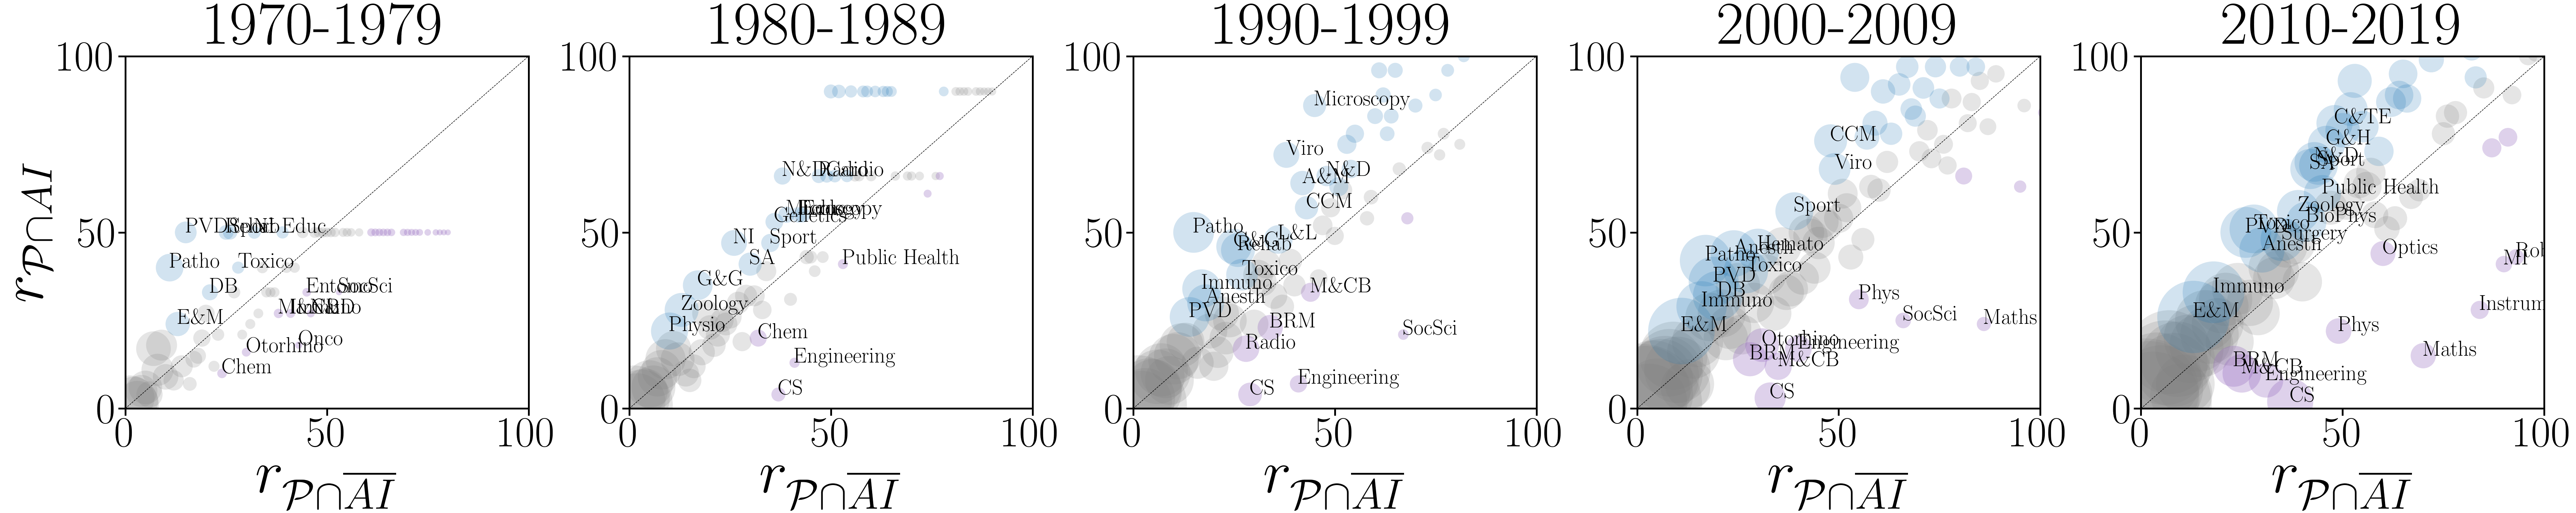

In [117]:
plot_2D_ranking_diagram(direction='imp', # 'imp' or 'imp'
                            is_agg=True, # bool
                            ranking_table=ranking_imp_agg,
                            Neuro_citation_counts=Neuro_windowedDf_imp_agg,
                            Neuro_citation_counts_prop=Neuro_windowedDf_imp_agg_prop,
                            NeuroAI_citation_counts=NeuroAI_windowedDf_imp_agg,
                            NeuroAI_citation_counts_prop=NeuroAI_windowedDf_imp_agg_prop,
                            tolerance_around_diagonal=10,
                            maxprop_discipline_to_display=0.01, # we want only for each point the points whose size is higher than the max size in the data
                            rank_lim_showtext=(100,50),
                            axis_lim=100,
                            is_zoom=False,
                            zoom=100,
                            tolerance_around_diagonal_zoom=10,
                            figsize=(100,20),
                            size_axisLabel=170,
                            size_ticksLabel=120,                            
                            print_disciplines_labels=True,
                            size_disciplineLabel=60,
                            resolution_size_point=50, # increase the size of the points in the plot
                            wos_abb=wos_abb,
                            save_folder=path_output)

# Compute the temporal evolution of the mean angle produced by the disciplines in each zone of the previous 2D maps (grey, blue and purple)

In [122]:
# ranking Neuro
ranking_ref_Neuro_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(Neuro_disciplines_ref_agg))
ranking_imp_Neuro_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(Neuro_disciplines_imp_agg))
# ranking NeuroAI
ranking_ref_NeuroAI_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(NeuroAI_disciplines_ref_agg))
ranking_imp_NeuroAI_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(NeuroAI_disciplines_imp_agg))

In [132]:
# Function that returns at each year the angles of the disciplines
# and their respective zone inside, above or below the tolerance zone.

# If a discipline is referenced in only one of the corpora, we add the maximal psossible rank inside the 
# other corpus, here the variable 'max_rank' (here 100).

def get_angle_disciplines_from_rankings(year,
                                        rx,
                                        ry,
                                        max_rank,
                                        Neuro_citation_counts,
                                        Neuro_citation_counts_prop,
                                        NeuroAI_citation_counts,
                                        NeuroAI_citation_counts_prop,
                                        tolerance,
                                        disc2discard,
                                        maxprop_discipline_to_consider):
    
    # take all the disciplines, and for those that are not common
    # disciplines = (set(rx[(rx[year]!=-1)&(rx[year]<=max_rank)].index) | set(ry[(ry[year]!=-1)&(ry[year]<=max_rank)].index))-set(disc2discard)
    disciplines_x = set(rx[(rx[year]!=-1)&(rx[year]<=max_rank)].index)-set(disc2discard)
    disciplines_y = set(ry[(ry[year]!=-1)&(ry[year]<=max_rank)].index)-set(disc2discard)
    
    #print(year)
    #print(disciplines)
    
    # get coordinates of the points
    xy = {}
    s = {}
    angle = {}
    for d in (disciplines_x | disciplines_y):
        if (d in disciplines_x) & (d in disciplines_y):
            xy[d] = (rx[year][d],ry[year][d])
            s[d] = (Neuro_citation_counts[year][d]*Neuro_citation_counts_prop[year][d]+NeuroAI_citation_counts[year][d]*NeuroAI_citation_counts_prop[year][d])/(Neuro_citation_counts_prop[year][d]+NeuroAI_citation_counts_prop[year][d])
        elif d not in disciplines_x:
            xy[d] = (max_rank,ry[year][d])
            s[d] = NeuroAI_citation_counts[year][d]
        elif d not in disciplines_y:
            xy[d] = (rx[year][d],max_rank)
            s[d] = Neuro_citation_counts[year][d]
        angle[d] = (-np.pi/4)+np.arctan(xy[d][1]/xy[d][0])
        
    # convert it to square root in order to flatten the values and the variance, better than log that flattens stronger
    s_sqrt = {i: np.sqrt(s[i]) for i in s.keys()}
    s_sqrt_values = np.array(list(s_sqrt.values()))
        
    # select the indices of the disciplines we want to show, based on the size here
    ind2show = np.where(np.array(s_sqrt_values) >= maxprop_discipline_to_consider*np.nanmax(s_sqrt_values))[0]
    disc2show = [list(xy.keys())[i] for i in ind2show]
    
    print(max(s_sqrt_values))
    print(f'Ind to show:{ind2show}')
    print(f'To show:{disc2show}')

    # distinguish the disciplines that are in the tolerance zone from those at the bording zone or outside
    # search the indices within the vector of size s
    disciplines_zone = {i:[] for i in ['in','out_bottom','out_top']}
    for i in disc2show:
        if (xy[i][1] > xy[i][0]-tolerance) & (xy[i][1] < xy[i][0]+tolerance):
            disciplines_zone['in'].append(i)
        elif xy[i][1] < xy[i][0]-tolerance:
            disciplines_zone['out_bottom'].append(i)
        elif xy[i][1] > xy[i][0]+tolerance:
            disciplines_zone['out_top'].append(i)
        
    return angle, disciplines_zone

In [135]:
legend = [r'$r_{\mathcal{P}\cap AI} \sim_{\tau} r_{\mathcal{P}\cap\overline{AI}}$',
          r'$r_{\mathcal{P}\cap AI} < r_{\mathcal{P}\cap\overline{AI}}-\tau$',
          r'$r_{\mathcal{P}\cap AI} > r_{\mathcal{P}\cap\overline{AI}}+\tau$']

### References

In [133]:
angles_year = {}
disciplines_zones_year = {}

for y in range(1970,2021):
    angles, disciplines_zones = get_angle_disciplines_from_rankings(
                                  year=str(y),
                                  rx=ranking_ref_Neuro_allyears_agg,
                                  ry=ranking_ref_NeuroAI_allyears_agg,
                                  max_rank=100,
                                  Neuro_citation_counts=Neuro_disciplines_ref_agg,
                                  Neuro_citation_counts_prop=Neuro_disciplines_ref_agg_prop,
                                  NeuroAI_citation_counts=NeuroAI_disciplines_ref_agg,
                                  NeuroAI_citation_counts_prop=NeuroAI_disciplines_ref_agg_prop,
                                  tolerance=10,
                                  disc2discard=[],
                                  maxprop_discipline_to_consider=0.01)
    
    disciplines_zones_year[y] = disciplines_zones
    angles_year[y] = angles

keys = ['in', 'out_bottom', 'out_top']
angles_NeuroNeuroAI_ref_allyears_agg = {k:{y:[angles_year[y][d] for d in disciplines_zones_year[y][k]]
                                           for y in range(1970,2021)}
                                        for k in keys}

angles_NeuroNeuroAI_ref_allyears_agg = pd.DataFrame(angles_NeuroNeuroAI_ref_allyears_agg)
mean_angles_zones = {k:{y:np.mean(angles_NeuroNeuroAI_ref_allyears_agg[k][y]) 
                        for y in range(1970,2021)} 
                     for k in keys}
std_angles_zones = {k:{y:np.std(angles_NeuroNeuroAI_ref_allyears_agg[k][y]) 
                        for y in range(1970,2021)} 
                     for k in keys}

65.09584296877465
Ind to show:[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
To show:['Biology', 'Optics', 'Education & Educational Research', 'Medical Laboratory Technology', 'Obstetrics & Gynecology', 'Gastroenterology & Hepatology', 'Veterinary Sciences', 'Oceanography', 'Education', 'Fisheries', 'Peripheral Vascular Diseases', 'Critical Care Medicine', 'Orthopedics', 'Materials Science', 'Otorhinolaryngology', 'Plant Sciences', 'Radiology', 'Language & Linguistics', 'Biochemistry & Molecular Biology', 'Ecology', 'Biophysics', 'Mycology', 'Surgery', 'Entomology', 'Astronomy & Astrophysics', 'Audiology & Speech-Language Pa

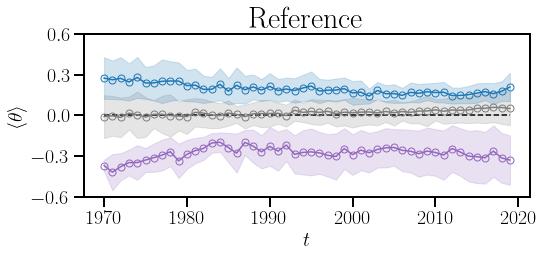

In [139]:
fig = plt.figure(figsize=(8, 3))
plt.rc('axes', linewidth=2)
ax = plt.axes()
cmap = plt.cm.tab20.colors
colors = [cmap[14], cmap[8], cmap[0]]
ax.plot(np.arange(1970,2020,1), [0]*50, '--', color='black')
j = 0
for i in ['in', 'out_bottom', 'out_top']:
    m = list(mean_angles_zones[i].values())[:-1]
    s = list(std_angles_zones[i].values())[:-1]
    ax.plot(np.arange(1970,2020,1), m, 'o-', ms=7, mfc='none', color=colors[j])
    ax.fill_between(np.arange(1970, 2020, 1),
                    [x+y for x,y in zip(m,s)],
                    [x-y for x,y in zip(m,s)],
                    alpha=0.2,
                    color=colors[j])
    j+=1
    #axins.plot(np.arange(1970,2020,1), std_angles_zones[keys[i]][:-1], 'o-', ms=4, linewidth=0.5, mfc='none', color=colors[i])
ax.set_ylim(-0.6, 0.6)
ax.set_yticks(np.arange(-0.6,0.61,0.3))
#ax.yscale('symlog')
ax.set_title(r'Reference', fontsize=titleSize)
ax.set_xticks([i for i in range(1970, 2021, 10)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
ax.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$\langle\theta\rangle$', fontsize=20)

#plt.tight_layout()
plt.savefig(f'{path_output}angles_mean_std_withTol10_ref_agg.svg', format='svg', bbox_inches='tight')
plt.show()

### Impact

In [140]:
angles_year = {}
disciplines_zones_year = {}

for y in range(1970,2021):
    angles, disciplines_zones = get_angle_disciplines_from_rankings(
                                  year=str(y),
                                  rx=ranking_imp_Neuro_allyears_agg,
                                  ry=ranking_imp_NeuroAI_allyears_agg,
                                  max_rank=100,
                                  Neuro_citation_counts=Neuro_disciplines_imp_agg,
                                  Neuro_citation_counts_prop=Neuro_disciplines_imp_agg_prop,
                                  NeuroAI_citation_counts=NeuroAI_disciplines_imp_agg,
                                  NeuroAI_citation_counts_prop=NeuroAI_disciplines_imp_agg_prop,
                                  tolerance=10,
                                  disc2discard=[],
                                  maxprop_discipline_to_consider=0.01)
    
    disciplines_zones_year[y] = disciplines_zones
    angles_year[y] = angles

keys = ['in', 'out_bottom', 'out_top']
angles_NeuroNeuroAI_imp_allyears_agg = {k:{y:[angles_year[y][d] for d in disciplines_zones_year[y][k]]
                                           for y in range(1970,2021)}
                                        for k in keys}

angles_NeuroNeuroAI_imp_allyears_agg = pd.DataFrame(angles_NeuroNeuroAI_imp_allyears_agg)
mean_angles_zones = {k:{y:np.mean(angles_NeuroNeuroAI_imp_allyears_agg[k][y]) 
                        for y in range(1970,2021)} 
                     for k in keys}
std_angles_zones = {k:{y:np.std(angles_NeuroNeuroAI_imp_allyears_agg[k][y]) 
                        for y in range(1970,2021)} 
                     for k in keys}

111.69261648383963
Ind to show:[ 0  1  2  3  4  6  7  9 10 12 13 14 15 16 17 18 19 23 24 25 26 27 28 29
 30 31 32 33 34 35 37 39 40 41 42 43 45 46 47 48 49 50 51 52 54 55 56 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 80 81 82]
To show:['Biology', 'Optics', 'Education & Educational Research', 'Medical Laboratory Technology', 'Obstetrics & Gynecology', 'Veterinary Sciences', 'Education', 'Peripheral Vascular Diseases', 'Plant Sciences', 'Radiology', 'Biochemistry & Molecular Biology', 'Ecology', 'Biophysics', 'Surgery', 'Audiology & Speech-Language Pathology', 'Entomology', 'Immunology', 'Rehabilitation', 'Allergy', 'Physiology', 'Management', 'Neurosciences', 'Chemistry', 'Hematology', 'Behavioral Sciences', 'Sport Sciences', 'Agriculture', 'Microbiology', 'Computer Science', 'Pharmacology & Pharmacy', 'Ornithology', 'Environmental Sciences', 'Oncology', 'Engineering', 'Toxicology', 'Cardiac & Cardiovascular System', 'Virology', 'Communication', 'Food Science & Tech

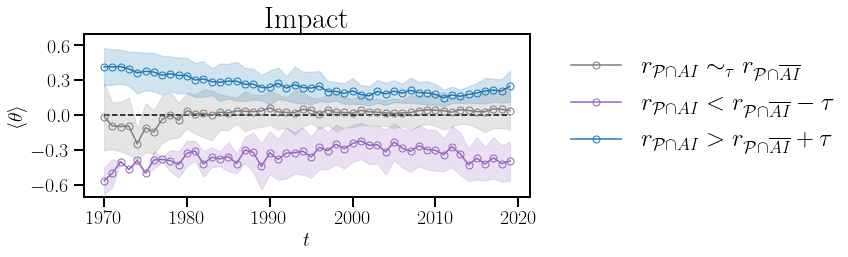

In [145]:
fig = plt.figure(figsize=(8, 3))
ax = plt.axes()
cmap = plt.cm.tab20.colors
legend = [r'$r_{\mathcal{P}\cap AI} \sim_{\tau} r_{\mathcal{P}\cap\overline{AI}}$',
          r'$r_{\mathcal{P}\cap AI} < r_{\mathcal{P}\cap\overline{AI}}-\tau$',
          r'$r_{\mathcal{P}\cap AI} > r_{\mathcal{P}\cap\overline{AI}}+\tau$']
colors = [cmap[14], cmap[8], cmap[0]]
ax.plot(np.arange(1970,2020,1), [0]*50, '--', color='black')
j = 0
for i in ['in', 'out_bottom', 'out_top']:
    m = list(mean_angles_zones[i].values())[:-1]
    s = list(std_angles_zones[i].values())[:-1]
    ax.plot(np.arange(1970,2020,1), m, 'o-', ms=7, mfc='none', color=colors[j], label=legend[j])
    ax.fill_between(np.arange(1970, 2020, 1),
                    [x+y for x,y in zip(m,s)],
                    [x-y for x,y in zip(m,s)],
                    alpha=0.2,
                    color=colors[j])
    j+=1
    #axins.plot(np.arange(1970,2020,1), std_angles_zones[keys[i]][:-1], 'o-', ms=4, linewidth=0.5, mfc='none', color=colors[i])
ax.set_ylim(-0.7, 0.7)
ax.set_yticks(np.arange(-0.6,0.61,0.3))
#ax.yscale('symlog')
ax.set_title(r'Impact', fontsize=titleSize)
ax.set_xticks([i for i in range(1970, 2021, 10)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
ax.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$\langle\theta\rangle$', fontsize=20)

ax.legend(bbox_to_anchor=(1.04, 1.0), ncol=1, fontsize=25, frameon=False)
#plt.tight_layout()
plt.savefig(f'{path_output}angles_mean_std_withTol10_imp_agg.svg', format='svg', bbox_inches='tight')
plt.show()

# Plot the temporal ranks of the disciplines in the preferential zone of $\mathcal{P}\cap AI$

In [146]:
# ranking Neuro
ranking_ref_Neuro_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(Neuro_disciplines_ref_agg))
ranking_imp_Neuro_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(Neuro_disciplines_imp_agg))
# ranking NeuroAI
ranking_ref_NeuroAI_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(NeuroAI_disciplines_ref_agg))
ranking_imp_NeuroAI_allyears_agg = pd.DataFrame.from_records(get_rankings_with_exaequo(NeuroAI_disciplines_imp_agg))

### References

In [184]:
disc2show_increase = []
v_increase = []
disc2show_decrease = []
v_decrease = []
for d in ranking_ref_NeuroAI_allyears_agg.index:
    ind = np.argwhere(~np.isnan(ranking_ref_NeuroAI_allyears_agg.loc[d,:].values))[0][0]
    begin_year = ranking_ref_NeuroAI_allyears_agg.columns[ind]
    if (ranking_ref_NeuroAI_allyears_agg.loc[d,begin_year]<15) & (ranking_ref_NeuroAI_allyears_agg.loc[d,'2019']>20):
        disc2show_decrease.append(d)
        v_decrease.append(ranking_ref_NeuroAI_allyears_agg.loc[d,'2019'])
    elif (ranking_ref_NeuroAI_allyears_agg.loc[d,begin_year]>15) & (ranking_ref_NeuroAI_allyears_agg.loc[d,'2019']<15):
        disc2show_increase.append(d)
        v_increase.append(ranking_ref_NeuroAI_allyears_agg.loc[d,'2019'])
disc2show_decrease = [disc2show_decrease[d] for d in reversed(np.argsort(v_decrease))]
disc2show_increase = [disc2show_increase[d] for d in reversed(np.argsort(v_increase))]

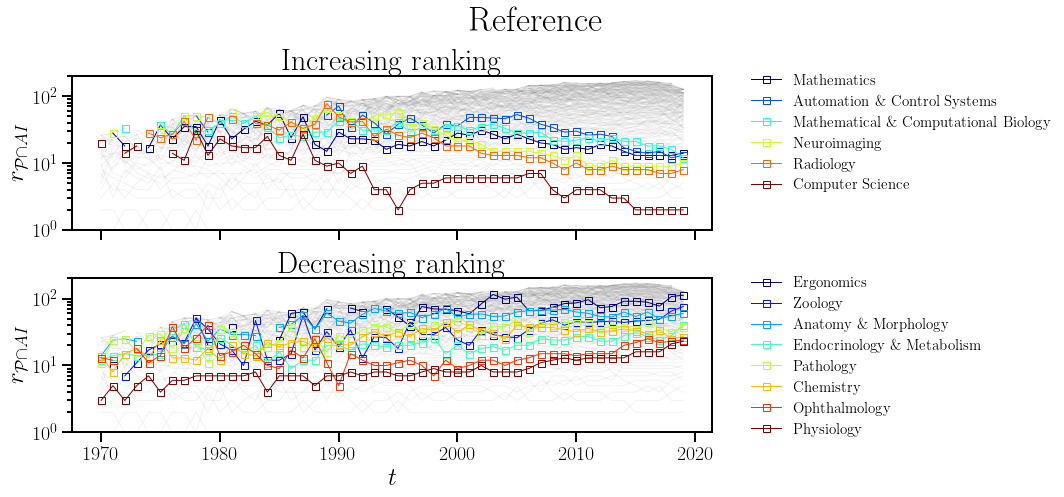

In [185]:
fig, axs = plt.subplots(2, 1, figsize=(15,7))
fig.suptitle('Reference', fontsize=titleSize+5, ha='center')
disc2show = [disc2show_increase, disc2show_decrease]
for k in range(2):
    j = 0
    for d in set(ranking_ref_NeuroAI_allyears_agg.index)-set(disc2show[k]):
        axs[k].plot(np.arange(1970, 2020, 1), ranking_ref_NeuroAI_allyears_agg.loc[d,:][:-1], '-', c='grey', linewidth=1, alpha=0.1)
    cmap = plt.cm.jet(np.linspace(0,1,len(disc2show[k])))
    for d in disc2show[k]:    
        axs[k].plot(np.arange(1970, 2020, 1), ranking_ref_NeuroAI_allyears_agg.loc[d,:][:-1], 's-', c=cmap[j], ms=7, mfc='none', linewidth=1, label=d.replace('&','\&'))
        j += 1
    axs[k].set_ylabel(r'$r_{\mathcal{P}\cap AI}$', fontsize=axisLabelSize)
    #plt.title(r'Reference', fontsize=titleSize)
    axs[k].tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
    axs[k].tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
    axs[k].legend(bbox_to_anchor=(1.04, 1.1), ncol=1, fontsize=legendSize-5, frameon=False)
    axs[k].set_yscale('log')
    axs[k].set_ylim(1,200)
axs[0].set_xticks(np.arange(1970, 2021, 10),[])
axs[1].set_xlabel(r'$t$', fontsize=axisLabelSize)
axs[0].set_title('Increasing ranking', fontsize=titleSize)
axs[1].set_title('Decreasing ranking', fontsize=titleSize)
plt.tight_layout()
plt.savefig(f'{path_output}year_ranking_NeuroAI_ref_agg_topIncrease1520_bottomIncrease1515.svg', format='svg', bbox_inches='tight')
plt.show()

### Impact

In [186]:
disc2show_increase = []
v_increase = []
disc2show_decrease = []
v_decrease = []
for d in ranking_imp_NeuroAI_allyears_agg.index:
    ind = np.argwhere(~np.isnan(ranking_imp_NeuroAI_allyears_agg.loc[d,:].values))[0][0]
    begin_year = ranking_imp_NeuroAI_allyears_agg.columns[ind]
    if (ranking_imp_NeuroAI_allyears_agg.loc[d,begin_year]<10) & (ranking_imp_NeuroAI_allyears_agg.loc[d,'2019']>40):
        disc2show_decrease.append(d)
        v_decrease.append(ranking_imp_NeuroAI_allyears_agg.loc[d,'2019'])
    elif (ranking_imp_NeuroAI_allyears_agg.loc[d,begin_year]>10) & (ranking_imp_NeuroAI_allyears_agg.loc[d,'2019']<10):
        disc2show_increase.append(d)
        v_increase.append(ranking_imp_NeuroAI_allyears_agg.loc[d,'2019'])
disc2show_decrease = [disc2show_decrease[d] for d in reversed(np.argsort(v_decrease))]
disc2show_increase = [disc2show_increase[d] for d in reversed(np.argsort(v_increase))]

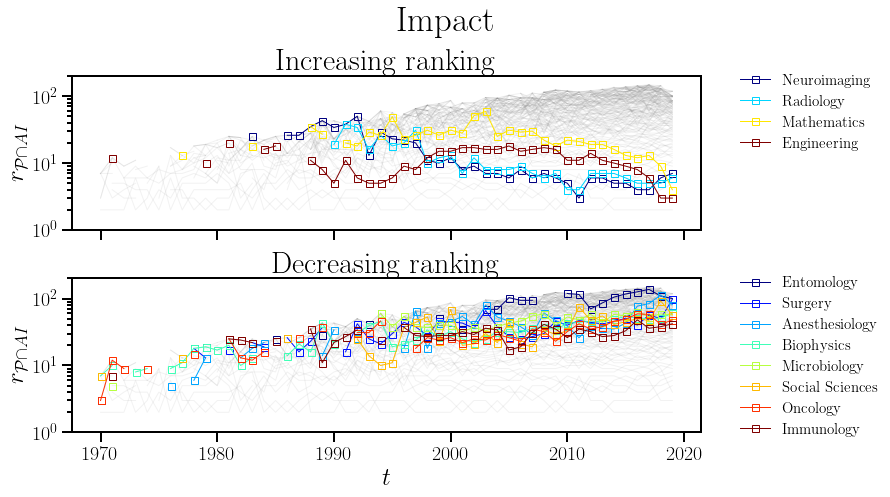

In [187]:
fig, axs = plt.subplots(2, 1, figsize=(12.5,7))
fig.suptitle('Impact', fontsize=titleSize+5, ha='center')
disc2show = [disc2show_increase, disc2show_decrease]
for k in range(2):
    j = 0
    for d in set(ranking_imp_NeuroAI_allyears_agg.index)-set(disc2show[k]):
        axs[k].plot(np.arange(1970, 2020, 1), ranking_imp_NeuroAI_allyears_agg.loc[d,:][:-1], '-', c='grey', linewidth=1, alpha=0.1)
    cmap = plt.cm.jet(np.linspace(0,1,len(disc2show[k])))
    for d in disc2show[k]: 
        axs[k].plot(np.arange(1970, 2020, 1), ranking_imp_NeuroAI_allyears_agg.loc[d,:][:-1], 's-', c=cmap[j], ms=7, mfc='none', linewidth=1, label=d.replace('&','\&'))
        j += 1
    axs[k].set_ylabel(r'$r_{\mathcal{P}\cap AI}$', fontsize=axisLabelSize)
    #plt.title(r'imperence', fontsize=titleSize)
    axs[k].tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
    axs[k].tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
    axs[k].legend(bbox_to_anchor=(1.04, 1.1), ncol=1, fontsize=legendSize-5, frameon=False)
    axs[k].set_yscale('log')
    axs[k].set_ylim(1,200)
axs[0].set_xticks(np.arange(1970, 2021, 10),[])
axs[1].set_xlabel(r'$t$', fontsize=axisLabelSize)
axs[0].set_title('Increasing ranking', fontsize=titleSize)
axs[1].set_title('Decreasing ranking', fontsize=titleSize)
fig.tight_layout()
plt.savefig(f'{path_output}year_ranking_NeuroAI_imp_agg_topIncrease_bottomIncrease_15_25.svg', format='svg', bbox_inches='tight')
plt.show()

# Check the evolution of main disciplines in common interest zone, checking the distance $\rho$ with the origin

In [188]:
# ranking Neuro
ranking_ref_Neuro_allyears_agg.fillna(-1, inplace=True)
ranking_imp_Neuro_allyears_agg.fillna(-1, inplace=True)
# ranking NeuroAI
ranking_ref_NeuroAI_allyears_agg.fillna(-1, inplace=True)
ranking_imp_NeuroAI_allyears_agg.fillna(-1, inplace=True)

In [202]:
t = 10
p = 0.5
threshold = 15

# REF
# check if the disciplines are in the common interest zone at least once
disciplines = set(ranking_ref_Neuro_allyears_agg.index) & set(ranking_ref_NeuroAI_allyears_agg.index)
inside_ref = {d:[] for d in disciplines}
for period in ranking_ref_Neuro_allyears_agg.columns:
    xy = {d:(ranking_ref_NeuroAI_allyears_agg[period][d],ranking_ref_Neuro_allyears_agg[period][d])
           for d in disciplines if (ranking_ref_NeuroAI_allyears_agg[period][d]!=-1) & (ranking_ref_Neuro_allyears_agg[period][d]!=-1)}
    for i in disciplines:
        if i in xy.keys():
            if (xy[i][1] >= xy[i][0]-t) & (xy[i][1] <= xy[i][0]+t):
                inside_ref[i].append(1)
            else:
                inside_ref[i].append(0)
        else:
            inside_ref[i].append(0)
# only for the disciplines that are in the zone at 50% of its time, compute its size 
rho_ref = {d:[] for d in inside_ref.keys() if len(np.where(np.array(inside_ref[d])==1)[0]) >= p*len(inside_ref[d])}
for period in ranking_ref_Neuro_allyears_agg.columns:
    xy = {d:(ranking_ref_NeuroAI_allyears_agg[period][d],ranking_ref_Neuro_allyears_agg[period][d])
           for d in disciplines if (ranking_ref_NeuroAI_allyears_agg[period][d]!=-1) & (ranking_ref_Neuro_allyears_agg[period][d]!=-1)}
    for i in rho_ref.keys():
        if i in xy.keys():
            rho_ref[i].append(np.sqrt(xy[i][0]**2+xy[i][1]**2))
        else:
            rho_ref[i].append(np.nan)
# sort rho ref:
ind = reversed(np.argsort([rho_ref[d][-1] for d in rho_ref.keys()]))
rho_ref = {d:rho_ref[d] for d in [list(rho_ref.keys())[j] for j in ind]}
# select the decrease and increase
disc_decrease_ref = []
disc_increase_ref = []
for d in rho_ref.keys():
    ind = np.where(~np.isnan(np.array(rho_ref[d])))[0][0]
    if rho_ref[d][ind] > rho_ref[d][-1]+threshold:
        disc_increase_ref.append(d)
    elif rho_ref[d][ind] < rho_ref[d][-1]-threshold:
        disc_decrease_ref.append(d)     

# IMP
disciplines = set(ranking_imp_Neuro_allyears_agg.index) & set(ranking_imp_NeuroAI_allyears_agg.index)
inside_imp = {d:[] for d in disciplines}
for period in ranking_imp_Neuro_allyears_agg.columns:
    xy = {d:(ranking_imp_NeuroAI_allyears_agg[period][d],ranking_imp_Neuro_allyears_agg[period][d])
           for d in disciplines if (ranking_imp_NeuroAI_allyears_agg[period][d]!=-1) & (ranking_imp_Neuro_allyears_agg[period][d]!=-1)}
    for i in disciplines:
        if i in xy.keys():
            if (xy[i][1] >= xy[i][0]-t) & (xy[i][1] <= xy[i][0]+t):
                inside_imp[i].append(1)
            else:
                inside_imp[i].append(0)
        else:
            inside_imp[i].append(0)
# only for the disciplines that are in the zone at 50% of its time, compute its size 
rho_imp = {d:[] for d in inside_imp.keys() if len(np.where(np.array(inside_imp[d])==1)[0]) >= p*len(inside_imp[d])}
for period in ranking_imp_Neuro_allyears_agg.columns:
    xy = {d:(ranking_imp_NeuroAI_allyears_agg[period][d],ranking_imp_Neuro_allyears_agg[period][d])
           for d in disciplines if (ranking_imp_NeuroAI_allyears_agg[period][d]!=-1) & (ranking_imp_Neuro_allyears_agg[period][d]!=-1)}
    for i in rho_imp.keys():
        if i in xy.keys():
            rho_imp[i].append(np.sqrt(xy[i][0]**2+xy[i][1]**2))
        else:
            rho_imp[i].append(np.nan)
ind = reversed(np.argsort([rho_imp[d][-1] for d in rho_imp.keys()]))
rho_imp = {d:rho_imp[d] for d in [list(rho_imp.keys())[j] for j in ind]}
# select the decrease and increase
disc_decrease_imp = []
disc_increase_imp = []
for d in rho_imp.keys():
    ind = np.where(~np.isnan(np.array(rho_imp[d])))[0][0]
    if rho_imp[d][ind] > rho_imp[d][-1]+threshold:
        disc_increase_imp.append(d)
    elif rho_imp[d][ind] < rho_imp[d][-1]-threshold:
        disc_decrease_imp.append(d) 

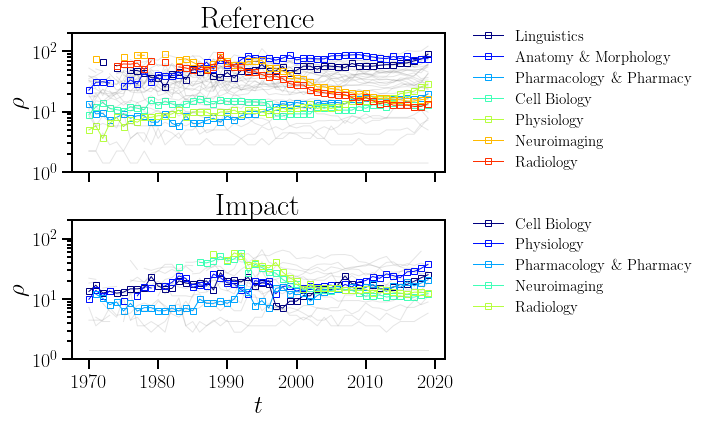

In [203]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))
data = [rho_ref, rho_imp]
data_color = [disc_increase_ref, disc_decrease_ref, disc_increase_imp, disc_decrease_imp]
for k in range(2):
    j = 0
    cmap = plt.cm.jet(np.linspace(0,1,3+max([len(i) for i in data_color[k:k+2]])))
    for d in data[k].keys():
        if (d in data_color[k]+data_color[k+1]) & (d not in ['Neurosciences']):
            if d == 'Public':
                label = 'Public, Environmental \& Occupational Health'
            else:
                label = d.replace('&','\&')
            axs[k].plot(np.arange(1970, 2020, 1), data[k][d][:-1], 's-', mfc='none', c=cmap[j], linewidth=1, label=label, alpha=1)
            j+=1
        else:
            axs[k].plot(np.arange(1970, 2020, 1), data[k][d][:-1], '-', c='grey', linewidth=1, alpha=0.2)
    axs[k].set_ylabel(r'$\rho$', fontsize=axisLabelSize)
    #plt.title(r'imperence', fontsize=titleSize)
    axs[k].tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
    axs[k].tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
    axs[k].legend(bbox_to_anchor=(1.04, 1.12), ncol=1, fontsize=legendSize-5, frameon=False)
    axs[k].set_yscale('log')
    axs[k].set_ylim(1,200)
axs[0].set_xticks(np.arange(1970, 2021, 10),[])
axs[1].set_xlabel(r'$t$', fontsize=axisLabelSize)
axs[0].set_title('Reference', fontsize=titleSize)
axs[1].set_title('Impact', fontsize=titleSize)
plt.tight_layout()
plt.savefig(f'{path_output}year_ranking_NeuroNeuroAI_commoninterestzone_agg.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Compute extended Jaccard similarities of the temporal rankings

In [280]:
# rankings a and b are ordered lists that are decreasing, ie. [...,d3,d2,d1]
# we suppose same size of ranking for a and b
def extended_jaccard(ranking_a,ranking_b):
    ra = {k:i for k,i in zip(ranking_a, range(1,len(ranking_a)+1))}
    rb = {k:i for k,i in zip(ranking_b, range(1,len(ranking_b)+1))}
    #print(ra,rb)
    
    # compute the intersection
    common_keys = set(ra.keys()) & set(rb.keys())
    #print(common_keys)
    num = 0 
    for d in common_keys:
        num += min(ra[d],rb[d])
    
    # compute the union
    denom = 0
    # initialization with the count of not common keys
    for ranking in [ra,rb]:
        denom += sum([ranking[d] for d in set(ranking.keys())-common_keys])
    for d in common_keys:
        denom += max(ra[d],rb[d])
    
    return num/denom

# --------------DISCIPLINES----------------
# don't remove the neuroscience because it is not always in first position

def windowed_ranking_distance(ranking,top,window):
    years = sorted([int(y) for y in list(ranking.keys())])
    ranking_distance = []
    for y in years[2::window]:
        ra = list(ranking[str(y-window)].keys())[-top:]
        rb = list(ranking[str(y)].keys())[-top:]
        ranking_distance.append((y,extended_jaccard(ra,rb)))
    return ranking_distance

# we suppose that ranking_a and ranking_b have the same keys
def cross_ranking_distance(ranking_a,ranking_b,top):
    years = sorted([int(y) for y in list(ranking_a.keys())])
    ranking_distance = []
    for y in years:
        ra = list(ranking_a[str(y)].keys())[-top:]
        rb = list(ranking_b[str(y)].keys())[-top:]
        ranking_distance.append((y,extended_jaccard(ra,rb)))
    return ranking_distance

In [281]:
time_window = 1
# N = 50
N_ref = max([len(Neuro_disciplines_ref[y]) for y in Neuro_disciplines_ref.keys()])
N_imp = max([len(Neuro_disciplines_imp[y]) for y in Neuro_disciplines_imp.keys()])
ranking_distance_Neuro_disciplines_ref_agg = windowed_ranking_distance(Neuro_disciplines_ref_agg,N_ref,time_window)
ranking_distance_NeuroAI_disciplines_ref_agg = windowed_ranking_distance(NeuroAI_disciplines_ref_agg,N_ref,time_window)
ranking_distance_Neuro_disciplines_imp_agg = windowed_ranking_distance(Neuro_disciplines_imp_agg,N_imp,time_window)
ranking_distance_NeuroAI_disciplines_imp_agg = windowed_ranking_distance(NeuroAI_disciplines_imp_agg,N_imp,time_window)

['Mechanics', 'Geography', 'Transportation', 'Geosciences', 'Literature', 'Health Care Sciences & Services', 'Health Policy & Services', 'Horticulture', 'Agronomy', 'Nuclear Science & Technology', 'Archaeology', 'Materials Science', 'Social Issues', 'Limnology', 'Agricultural Engineering', 'Andrology', 'Imaging Science & Photographic Technology', 'Business', 'Communication', 'Music', 'Mycology', 'Family Studies', 'Soil Science', 'Law', 'Philosophy', 'Art', 'Geochemistry & Geophysics', 'Astronomy & Astrophysics', 'Construction & Building Technology', 'Critical Care Medicine', 'Medical Informatics', 'Instruments & Instrumentation', 'Economics', 'Language & Linguistics', 'Nursing', 'Automation & Control Systems', 'Education', 'Oceanography', 'Respiratory System', 'Gerontology', 'Polymer Science', 'Environmental Sciences', 'Sociology', 'Anthropology', 'Rheumatology', 'Parasitology', 'Social Work', 'Urology & Nephrology', 'Orthopedics', 'Tropical Medicine', 'Dermatology', 'Fisheries', 'Educ

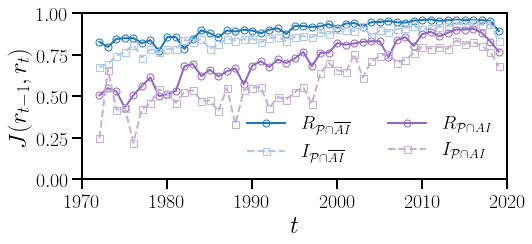

In [276]:
cmap = plt.cm.tab20.colors
legend = [r'$R_{\mathcal{P}\cap \overline{AI}}$', r'$I_{\mathcal{P}\cap \overline{AI}}$',
          r'$R_{\mathcal{P}\cap AI}$', r'$I_{\mathcal{P}\cap AI}$']
data = [ranking_distance_Neuro_disciplines_ref_agg, ranking_distance_Neuro_disciplines_imp_agg,
        ranking_distance_NeuroAI_disciplines_ref_agg, ranking_distance_NeuroAI_disciplines_imp_agg]
#colors = ['blue','blue','tomato','tomato']
colors = [cmap[0],cmap[1],cmap[8],cmap[9]]
lines = ['o-','s--','o-','s--']
fig = plt.figure(figsize=(7.5, 3.5))
ax = plt.axes()
for j in range(4):
    x = [i[0] for i in data[j][:-1]]
    y = [i[1] for i in data[j][:-1]]
    plt.plot(x, y, lines[j], c=colors[j], ms=7, mfc='none', linewidth=2, label=legend[j])
plt.xlabel(r'$t$', fontsize=axisLabelSize)
plt.ylabel(r'$J(r_{t-1},r_t)$', fontsize=axisLabelSize)
plt.xticks([i for i in range(1970, 2021, 10)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
ax.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
plt.legend(loc='lower right', ncol=2, fontsize=legendSize-1, frameon=False)
plt.ylim(0.,1)
plt.xlim(1970,2020)
plt.tight_layout()
plt.savefig(f'{path_output}year_ranking_distance_ref+imp_window{time_window}_agg.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [261]:
# N = 50
N_ref = max([len(Neuro_disciplines_ref[y]) for y in Neuro_disciplines_ref.keys()])
N_imp = max([len(Neuro_disciplines_imp[y]) for y in Neuro_disciplines_imp.keys()])
cross_ranking_distance_NeuroNeuroAI_disciplines_ref_agg = cross_ranking_distance(Neuro_disciplines_ref_agg, NeuroAI_disciplines_ref_agg,N_ref)
cross_ranking_distance_NeuroNeuroAI_disciplines_imp_agg = cross_ranking_distance(Neuro_disciplines_imp_agg, NeuroAI_disciplines_imp_agg,N_imp)

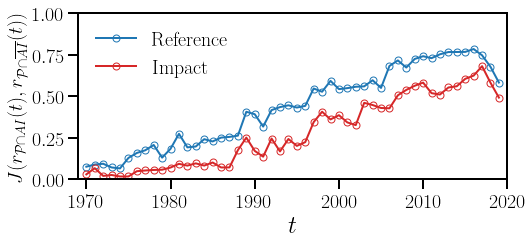

In [278]:
cmap = plt.cm.tab20.colors
legend = [r'Reference', r'Impact']
data = [cross_ranking_distance_NeuroNeuroAI_disciplines_ref_agg, cross_ranking_distance_NeuroNeuroAI_disciplines_imp_agg]
#colors = ['blue','blue','tomato','tomato']
colors = [cmap[0],cmap[6]]
lines = ['o-','o-']
fig = plt.figure(figsize=(7.5, 3.5))
ax = plt.axes()
for j in range(2):
    x = [i[0] for i in data[j][:-1]]
    y = [i[1] for i in data[j][:-1]]
    plt.plot(x, y, lines[j], c=colors[j], ms=7, mfc='none', linewidth=2, label=legend[j])
plt.xlabel(r'$t$', fontsize=axisLabelSize)
plt.ylabel(r'$J(r_{\mathcal{P}\cap AI}(t),r_{\mathcal{P}\cap \overline{AI}}(t))$', fontsize=axisLabelSize-5)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
ax.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
plt.legend(loc='upper left', ncol=1, fontsize=legendSize, frameon=False)
plt.ylim(0,1)
plt.xlim(1969,2020)
plt.tight_layout()
plt.savefig(f'{path_output}cross_ranking_distance_NeuroNeuroAI_ref+imp_agg.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [263]:
# Compare the rankings between the reference and the impact for each set
# assessing a concentration of most cited discipline or not year after year
#N = 20
N_ref = max([len(Neuro_disciplines_ref[y]) for y in Neuro_disciplines_ref.keys()])
N_imp = max([len(Neuro_disciplines_imp[y]) for y in Neuro_disciplines_imp.keys()])
cross_ranking_distance_Neuro_disciplines_refimp_agg = cross_ranking_distance(Neuro_disciplines_ref_agg, Neuro_disciplines_imp_agg,N_ref)
cross_ranking_distance_NeuroAI_disciplines_refimp_agg = cross_ranking_distance(NeuroAI_disciplines_ref_agg, NeuroAI_disciplines_imp_agg,N_imp)

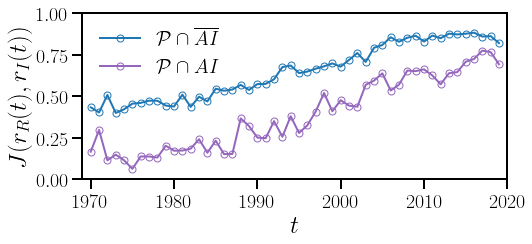

In [279]:
cmap = plt.cm.tab20.colors
legend = [r'$\mathcal{P}\cap \overline{AI}$', r'$\mathcal{P}\cap AI$']
data = [cross_ranking_distance_Neuro_disciplines_refimp_agg, cross_ranking_distance_NeuroAI_disciplines_refimp_agg]
#colors = ['blue','blue','tomato','tomato']
colors = [cmap[0],cmap[8]]
lines = ['o-','o-']
fig = plt.figure(figsize=(7.5, 3.5))
ax = plt.axes()
for j in range(2):
    x = [i[0] for i in data[j][:-1]]
    y = [i[1] for i in data[j][:-1]]
    plt.plot(x, y, lines[j], c=colors[j], ms=7, mfc='none', linewidth=2, label=legend[j])
plt.xlabel(r'$t$', fontsize=axisLabelSize)
plt.ylabel(r'$J(r_R(t),r_I(t))$', fontsize=axisLabelSize)
ax.tick_params(which='major', labelsize=ticksLabelSize, length=ticksSizeMajor, width=ticksWidth)
ax.tick_params(which='minor', length=ticksSizeMinor, width=ticksWidth)
plt.legend(loc='upper left', ncol=1, fontsize=legendSize, frameon=False)
plt.ylim(0,1)
plt.xlim(1969,2020)
plt.tight_layout()
plt.savefig(f'{path_output}cross_ranking_distance_refimp_Neuro_NeuroAI_agg_(concentration).pdf', format='pdf', bbox_inches='tight')
plt.show()